# Memecoin active trading strategy on Base

- Validate the strategy with Ethereum dataset

# Set up

Set up Trading Strategy data client.


In [1]:
import logging

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Collection of parameters used in the calculations

In [2]:
import datetime

import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.default_routing_options import TradeRouting


class Parameters:

    id = "32-eth-top-10"

    # We trade 1h candle
    candle_time_bucket = TimeBucket.h1
    cycle_duration = CycleDuration.cycle_1d
    
    # Coingecko categories to include
    #
    # See list here: TODO
    #
    chain_id = ChainId.ethereum
    categories = {"Meme"}
    exchanges = {"uniswap-v2", "uniswap-v3"}
    
    #
    # Basket construction and rebalance parameters
    #
    min_asset_universe = 3  # How many assets we need in the asset universe to start running the index
    max_assets_in_portfolio = 10  # How many assets our basket can hold once
    allocation = 0.95  # Allocate all cash to volatile pairs
    # min_rebalance_trade_threshold_pct = 0.05  # % of portfolio composition must change before triggering rebalacne
    individual_rebalance_min_threshold_usd = 75.0  # Don't make buys less than this amount
    min_volatility_threshold = 0.03  # Set to have Sharpe ratio threshold for the inclusion
    per_position_cap_of_pool = 0.33  # Never own more than % of the lit liquidity of the trading pool
    max_concentration = 0.33 # How large % can one asset be in a portfolio once
    min_portfolio_weight = 0.0050  # Close position / do not open if weight is less than 50 BPS
    
    #
    # Inclusion criteria parameters:
    # - We set the length of various indicators used in the inclusion criteria
    # - We set minimum thresholds neede to be included in the index to filter out illiquid pairs
    #

    # For the length of trailing sharpe used in inclusion criteria
    trailing_sharpe_bars = pd.Timedelta("14d") // candle_time_bucket.to_timedelta()  # How many bars to use in trailing sharpe indicator
    rebalance_volalitity_bars = pd.Timedelta("2d") // candle_time_bucket.to_timedelta()  # How many bars to use in volatility indicator
    returns_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()  # How many bars to use in volatility indicator
    rolling_volume_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    rolling_liquidity_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    ewm_span = 200  # How many bars to use in exponential moving average for trailing sharpe smoothing
    tvl_ewm_span = 200  # How many bars to use in EWM smoothing of TVLs
    min_volume = 50_000   # USD
    min_liquidity = 200_000  # USD
    min_tvl = 25_000  # USD
    min_token_sniffer_score = 30  # Scam filter
    
    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2022, 8, 15)
    backtest_end = datetime.datetime(2025, 1, 3)
    initial_cash = 10_000

    #
    # Live only
    #
    routing = TradeRouting.default
    required_history_period = datetime.timedelta(days=2*14 + 1)
    slippage_tolerance = 0.0060  # 0.6% 
    assummed_liquidity_when_data_missings = 10_000
    

parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation

# Trading pairs and market data

- This creates the strategy universe containing pair metadata and their prices
- The universe is "masked" by simply selecting pairs on the predefined pairs list

In [3]:
import warnings

from tradingstrategy.alternative_data.coingecko import CoingeckoUniverse, categorise_pairs
from tradingstrategy.chain import ChainId
from tradingstrategy.client import Client
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.utils.token_filter import deduplicate_pairs_by_volume
from tradingstrategy.client import Client
from tradingstrategy.client import Client
from tradingstrategy.utils.token_extra_data import filter_scams


from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data, OHLCVCandleType
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.analysis.pair import display_strategy_universe



#: Assets used in routing and buy-and-hold benchmark values for our strategy, but not traded by this strategy.
SUPPORTING_PAIRS = [
    (ChainId.ethereum, "uniswap-v2", "WETH", "USDC", 0.0030),  
    (ChainId.ethereum, "uniswap-v3", "cbBTC", "WETH", 0.0030),    # Only trading since October
]


# Will be converted to cbBTC/ETH->USDC
VOL_PAIR = (ChainId.ethereum, "uniswap-v2", "WETH", "USDC", 0.0030)


def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - Load Trading Strategy full pairs dataset

    - Load built-in Coingecko top 1000 dataset
    
    - Get all DEX tokens for a certain Coigecko category

    - Load OHCLV data for these pairs

    - Load also BTC and ETH price data to be used as a benchmark
    """

    chain_id = Parameters.chain_id
    categories = Parameters.categories

    coingecko_universe = CoingeckoUniverse.load()
    print("Coingecko universe is", coingecko_universe)

    exchange_universe = client.fetch_exchange_universe()
    pairs_df = client.fetch_pair_universe().to_pandas()

    # Drop other chains to make the dataset smaller to work with
    chain_mask = pairs_df["chain_id"] == Parameters.chain_id.value
    pairs_df = pairs_df[chain_mask]

    # Pull out our benchmark pairs ids.
    # We need to construct pair universe object for the symbolic lookup.
    pair_universe = PandasPairUniverse(pairs_df, exchange_universe=exchange_universe)
    benchmark_pair_ids = [pair_universe.get_pair_by_human_description(desc).pair_id for desc in SUPPORTING_PAIRS]

    # Assign categories to all pairs
    category_df = categorise_pairs(coingecko_universe, pairs_df)

    # Get all trading pairs that are memecoin, across all coingecko data
    mask = category_df["category"].isin(categories)
    category_pair_ids = category_df[mask]["pair_id"]

    our_pair_ids = list(category_pair_ids) + benchmark_pair_ids

    # From these pair ids, see what trading pairs we have on Ethereum mainnet
    pairs_df = pairs_df[pairs_df["pair_id"].isin(our_pair_ids)]

    # Limit by DEX
    pairs_df = pairs_df[pairs_df["exchange_slug"].isin(Parameters.exchanges)]

    # Never deduplicate supporrting pars
    supporting_pairs_df = pairs_df[pairs_df["pair_id"].isin(benchmark_pair_ids)]
    
    # Deduplicate trading pairs - Choose the best pair with the best volume
    deduplicated_df = deduplicate_pairs_by_volume(pairs_df)
    pairs_df = pd.concat([deduplicated_df, supporting_pairs_df]).drop_duplicates(subset='pair_id', keep='first')

    print(
        f"Total {len(pairs_df)} pairs to trade on {chain_id.name} for categories {categories}",        
    )

    # Scam filter using TokenSniffer
    pairs_df = filter_scams(pairs_df, client, min_token_sniffer_score=Parameters.min_token_sniffer_score)
    pairs_df = pairs_df.sort_values("volume", ascending=False)

    uni_v2 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v2"]
    uni_v3 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v3"]
    print(f"Pairs on Uniswap v2: {len(uni_v2)}, Uniswap v3: {len(uni_v3)}")

    dataset = load_partial_data(
        client=client,
        time_bucket=Parameters.candle_time_bucket,
        pairs=pairs_df,
        execution_context=execution_context,
        universe_options=universe_options,
        liquidity=True,
        liquidity_time_bucket=TimeBucket.d1,  
        liquidity_query_type=OHLCVCandleType.tvl_v2,
    )

    strategy_universe = TradingStrategyUniverse.create_from_dataset(
        dataset,
        reserve_asset="0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48",  
        forward_fill=True,  # We got very gappy data from low liquid DEX coins
    )

    # Tag benchmark/routing pairs tokens so they can be separated from the rest of the tokens
    # for the index construction.
    strategy_universe.warm_up_data()
    for pair_id in benchmark_pair_ids:
        pair = strategy_universe.get_pair_by_id(pair_id)
        pair.other_data["benchmark"] = True

    return strategy_universe


strategy_universe = create_trading_universe(
    None,
    client,
    notebook_execution_context,
    UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
)

display_strategy_universe(
    strategy_universe,
    sort_key="tvl",
    sort_ascending=False,
)


Coingecko universe is <CoingeckoUniverse for 2460 tokens>
Total 113 pairs to trade on ethereum for categories {'Meme'}
After scam filter we have 103 pairs
Scammy pair TRUMP - WETH, risk score 0.0, pool 0x56bc8f3293f53825c9fbd6ddfe0cafefa82820d0, token 0x6aa56e1d98b3805921c170eb4b3fe7d4fda6d89b
Scammy pair SHIRO - WETH, risk score 0.0, pool 0xd293d05e83035a757d510e2a5ebfe705c4f05b1f, token 0xb0ac2b5a73da0e67a8e5489ba922b3f8d582e058
Scammy pair BabyDoge - WETH, risk score 0.0, pool 0x9f2ebe69a86c079f3d4c3b94a11932b676b72f74, token 0xac57de9c1a09fec648e93eb98875b212db0d460b
Scammy pair VOLT - WETH, risk score 25.0, pool 0x96aa22baedc5a605357e0b9ae20ab6b10a472e03, token 0x7f792db54b0e580cdc755178443f0430cf799aca
Scammy pair GSWIFT - WETH, risk score nan, pool 0x715a3ceac0d039d674f50b07804592e87e8c6d77, token 0x580e933d90091b9ce380740e3a4a39c67eb85b4c
Scammy pair PEOPLE - WETH, risk score 25.0, pool 0x83abecf7204d5afc1bea5df734f085f2535a9976, token 0x7a58c0be72be218b41c608b7fe7c5bb630736c71

Data missing warning: We asked OHLCV data for 103 trading pairs, but only got for 102 pairs. This is usually because time period 2022-08-15 00:00:00 - 2025-01-03 00:00:00 does not have OHLCV data for all asked pairs.


Loading TVL/liquidity data for 103 pairs:   0%|          | 0/103 [00:00<?, ?it/s]

/Users/moo/code/trade-executor/deps/trading-strategy/tradingstrategy/transport/cache.py:912: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/Users/moo/code/trade-executor/tradeexecutor/analysis/pair.py:158: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



base quote    exchange  fee %      type:        price  \
id                                                                    
3010484       PEPE  WETH  uniswap-v2    0.3     traded         0.00   
1             WETH  USDC  uniswap-v2    0.3  benchmark      3451.52   
3226046        Mog  WETH  uniswap-v2    0.3     traded         0.00   
68900        FLOKI  WETH  uniswap-v2    0.3     traded         0.00   
3271833        SPX  WETH  uniswap-v2    0.3     traded         1.22   
37316         ELON  WETH  uniswap-v2    0.3     traded         0.00   
3073784    BITCOIN  WETH  uniswap-v3    1.0     traded         0.19   
4964467       CULT  WETH  uniswap-v3    1.0     traded         0.00   
3822814      Neiro  WETH  uniswap-v2    0.3     traded         0.00   
4368740      cbBTC  WETH  uniswap-v3    0.3  benchmark     96969.64   
3038307   pepecoin  WETH  uniswap-v2    0.3     traded         2.36   
3015124      WOJAK  WETH  uniswap-v2    0.3     traded         0.00   
4306260       DOGE  WETH  uniswap-v2    0.3     traded         0.17   
3573307       ANDY  WETH  uniswap-v2    0.3     traded         0.00   
3576318        APU  WETH  uniswap-v2    0.3     traded         0.00   
3242770        NPC  WETH  uniswap-v2    0.3     traded         0.02   
3634091       WOLF  WETH  uniswap-v2    0.3     traded         0.00   
3656844        GME  WETH  uniswap-v2    0.3     traded         0.00   
3073705       BOBO  WETH  uniswap-v2    0.3     traded         0.00   
4687332       SLAP  WETH  uniswap-v2    0.3     traded         0.00   
4974667       PEPU  WETH  uniswap-v3    0.3     traded         0.01   
3377643       GROK  WETH  uniswap-v2    0.3     traded         0.01   
4353961       PHIL  WETH  uniswap-v2    0.3     traded         0.02   
3347784        JOE  WETH  uniswap-v2    0.3     traded         0.03   
3061151      LADYS  WETH  uniswap-v2    0.3     traded         0.00   
4999091     KEKIUS  WETH  uniswap-v2    0.3     traded         0.16   
4367972     SQGROW  WETH  uniswap-v2    0.3     traded         0.03   
4702714       REKT  WETH  uniswap-v3    0.3     traded         0.00   
4372640    MOODENG  WETH  uniswap-v2    0.3     traded         0.00   
3660572       MAGA  WETH  uniswap-v2    0.3     traded         0.00   
3574910      HOPPY  WETH  uniswap-v2    0.3     traded         0.00   
3018875        BOB  WETH  uniswap-v2    0.3     traded         0.00   
3679558     PEIPEI  WETH  uniswap-v2    0.3     traded         0.00   
2785201      LMEOW  WETH  uniswap-v2    0.3     traded         0.03   
2713084        SHI  WETH  uniswap-v3    0.3     traded         0.00   
36926        KISHU  WETH  uniswap-v2    0.3     traded  <not avail>   
3350536       NATI  WETH  uniswap-v2    0.3     traded         0.00   
3822867      NEIRO  WETH  uniswap-v2    0.3     traded         0.04   
3026347       OSAK  WETH  uniswap-v2    0.3     traded         0.00   
3031971      JESUS  WETH  uniswap-v2    0.3     traded         0.00   
4611117    PATRIOT  WETH  uniswap-v2    0.3     traded         0.01   
5035055      SHIFU  WETH  uniswap-v2    0.3     traded         0.00   
3430630        ZYN  WETH  uniswap-v2    0.3     traded         0.03   
5066712        SEN  WETH  uniswap-v2    0.3     traded         0.32   
3698255      SHRUB  WETH  uniswap-v2    0.3     traded         0.04   
5001247       MOON  WETH  uniswap-v2    0.3     traded         0.00   
2697640       SHIB  WETH  uniswap-v3    0.3     traded         0.00   
3017331      TROLL  WETH  uniswap-v2    0.3     traded         0.00   
3054571        BAD  WETH  uniswap-v2    0.3     traded         0.00   
4636069        SBR  WETH  uniswap-v2    0.3     traded         0.96   
3367917      Kekec  WETH  uniswap-v2    0.3     traded         0.00   
3033402      $MONG  WETH  uniswap-v2    0.3     traded         0.00   
3311668   шайлушай  WETH  uniswap-v2    0.3     traded         0.00   
4394761       MSTR  WETH  uniswap-v2    0.3     traded         0.49   
3840058   TERMINUS  WETH  uniswap-v2  

### Asset to trading pair map

- Build a helper map
- Because we are operating on trading pairs, not on tokens, which are the base asset of a trading pair, we set up 
  this map to easily look up the selected trading pair by its symbol

In [4]:
from tradingstrategy.types import TokenSymbol
from tradeexecutor.state.identifier import TradingPairIdentifier

# Create base token symbol to pair map to help later
# Token
token_map: dict[TokenSymbol, TradingPairIdentifier] = {p.base.token_symbol: p for p in strategy_universe.iterate_pairs()}

# print(f"Pair count is {strategy_universe.get_pair_count()}")
# for symbol, pair in token_map.items():
#    print(f"{symbol} - #{pair.internal_id}")

# Tokens part of benchmark data, but not the strategy
benchmark_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is True]
category_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is not True]

print(f"Token map is {len(token_map)} assets")
print("Category trading pairs", len(category_pair_ids))
print("Benchmark trading pairs", len(benchmark_pair_ids))

Token map is 103 assets
Category trading pairs 101
Benchmark trading pairs 2


# Indicators

- Precalculate indicators used by the strategy

In [5]:
import pandas as pd
import numpy as np
from IPython.display import HTML

from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators_inline
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorDependencyResolver
from tradeexecutor.state.types import USDollarAmount
from tradeexecutor.strategy.pandas_trader.indicator_decorator import IndicatorRegistry


indicators = IndicatorRegistry()


@indicators.define()
def trailing_sharpe(
    close: pd.Series, 
    trailing_sharpe_bars: int
) -> pd.Series:
    """Calculate trailing 30d or so returns / standard deviation.

    :param length:
        Trailing period. 
    
    :return:
        Rolling cumulative returns / rolling standard deviation

        Note that this trailing sharpe is not annualised.
    """
    ann_factor = pd.Timedelta(days=365) / Parameters.candle_time_bucket.to_pandas_timedelta()
    returns = close.pct_change()
    mean_returns = returns.rolling(window=trailing_sharpe_bars).mean()    
    vol = returns.rolling(window=trailing_sharpe_bars).std()
    return mean_returns / vol * np.sqrt(ann_factor)


@indicators.define(dependencies=(trailing_sharpe,), source=IndicatorSource.dependencies_only_per_pair)
def trailing_sharpe_ewm(
    trailing_sharpe_bars: int,
    ewm_span: float,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Expontentially weighted moving average for Sharpe.

    :param ewm_span:
        How many bars to consider in the EVM

    """
    trailing_sharpe = dependency_resolver.get_indicator_data(
        "trailing_sharpe",
        pair=pair,
        parameters={"trailing_sharpe_bars": trailing_sharpe_bars},
    )    
    ewm = trailing_sharpe.ewm(span=ewm_span)
    return ewm.mean()


@indicators.define()
def volatility(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()
    return rolling_std



@indicators.define()
def signed_volatility(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    """Volatility with returns sign (profit or loss)."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()

    returns =  close \
        .rolling(window=rebalance_volalitity_bars) \
        .agg(lambda x: x.iloc[-1] - x.iloc[0])
    returns_sign = returns.apply(np.sign)
    return rolling_std * returns_sign


@indicators.define()
def rolling_returns(
    close: pd.Series, 
    returns_bars: int    
) -> pd.Series:
    """Rolling returns for the signal period."""

    def _agg_func(window: pd.Series) -> float:

        if len(window) < 2:
            return 0

        try:
            return (window.iloc[-1] - window.iloc[0]) / window.iloc[0]
        except Exception as e:
            raise # Drop into the debugger here

    returns = close.rolling(window=returns_bars).agg(_agg_func)
    return returns


@indicators.define(dependencies=[rolling_returns])
def volatility_returns_indicator(
    close: pd.Series, 
    rebalance_volalitity_bars: int,
    returns_bars: int,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Figure out some indicator to predict the price."""

    returns = dependency_resolver.get_indicator_data(
        rolling_returns,
        parameters={"returns_bars": returns_bars},
        pair=pair,
    )

    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()
    return rolling_std * returns



@indicators.define()
def volatility_ewm(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    # We are operating on 1h candles, 14d window
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()
    ewm = rolling_std.ewm(span=14*8)
    return ewm.mean()   


@indicators.define()
def mean_returns(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    # Descripton: TODO
    returns = close.pct_change()
    mean_returns = returns.rolling(window=rebalance_volalitity_bars).mean()    
    return mean_returns


@indicators.define()
def rolling_cumulative_volume(volume: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling volume of the pair.
    
    - Used in inclusion criteria
    """
    rolling_volume = volume.rolling(window=rolling_volume_bars).sum()
    return rolling_volume


@indicators.define()
def rolling_liquidity_avg(close: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling liquidity average

    - This is either TVL or XY liquidity (one sided) depending on the trading pair DEX type
    
    - Used in inclusion criteria
    """
    rolling_liquidity_close = close.rolling(window=rolling_volume_bars).mean()
    return  rolling_liquidity_close

    
@indicators.define(dependencies=(rolling_cumulative_volume,), source=IndicatorSource.strategy_universe)
def volume_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate pair volume inclusion criteria.

    - Avoid including illiquid / broken pairs in the set: Pair is included when it has enough volume 

    TODO: Add liquidity check later

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """

    series = dependency_resolver.get_indicator_data_pairs_combined(
        rolling_cumulative_volume,
        parameters={"rolling_volume_bars": rolling_volume_bars},
    )

    # Get mask for days when the rolling volume meets out criteria
    mask = series >= min_volume
    mask_true_values_only = mask[mask == True]

    # Turn to a series of lists
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series


@indicators.define(dependencies=(volatility_ewm,), source=IndicatorSource.strategy_universe)
def volatility_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate volatility inclusion criteria.

    - Include pairs that are above our threshold signal

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(
       volatility_ewm,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    threshold_pair = strategy_universe.get_pair_by_human_description(VOL_PAIR)
    assert threshold_pair
    threshold_signal = dependency_resolver.get_indicator_data(
        volatility_ewm,
        pair=threshold_pair,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    assert threshold_signal is not None, "No threshold volatility signal for: {threshold_pair}"

    # Get mask for days when the rolling volume meets out criteria,
    # and max out the threshold signal if there is
    # mask = filtered_series >= threshold_signal
    df = series.reset_index()
    df2 = df.merge(threshold_signal, on=["timestamp"], suffixes=('_pair', '_reference'))

    #         pair_id           timestamp  value_pair  value_reference
    # 0       4569519 2024-02-13 16:00:00    0.097836              NaN
    # 1       4569519 2024-02-13 17:00:00    0.097773              NaN

    high_volatility_rows = df2[df2["value_pair"] >= df2["value_reference"]]

    def _get_pair_ids_as_list(rows):
        return rows["pair_id"].tolist()
    
    # Turn to a series of lists
    series = high_volatility_rows.groupby(by=['timestamp']).apply(_get_pair_ids_as_list)
    assert isinstance(series, pd.Series)
    return series


@indicators.define(source=IndicatorSource.tvl)
def tvl(
    close: pd.Series,
) -> pd.Series:
    """Get TVL series for a pair.

    - Because TVL data is 1d and we use 1h everywhere else, we need to forward fill

    - Use previous hourly close as the value
    """
    return close.resample("1h").ffill()


@indicators.define(dependencies=(tvl,), source=IndicatorSource.dependencies_only_per_pair)
def tvl_ewm(
    pair: TradingPairIdentifier,
    tvl_ewm_span: float,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Get smoothed TVL series for a pair.

    - Interpretation: If you set span=5, for example, the ewm function will compute an exponential moving average where the weight of the most recent observation is about 33.3% (since α=2/(5+1)≈0.333) and this weight decreases exponentially for older observations.

    - We forward fill gaps, so there is no missing data in decide_trades()    

    - Currently unused in the strategy itself
    """
    tvl_ff = dependency_resolver.get_indicator_data(
        tvl,
        pair=pair,
    )    
    return tvl_ff.ewm(span=tvl_ewm_span).mean()


@indicators.define(dependencies=(tvl,), source=IndicatorSource.dependencies_only_universe)
def tvl_inclusion_criteria(   
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """The pair must have min XX,XXX USD one-sided TVL to be included.

    - If the Uniswap pool does not have enough ETH or USDC deposited, skip the pair as a scam

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(tvl)
    mask = series >= min_tvl
    # Turn to a series of lists
    mask_true_values_only = mask[mask == True]
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series



@indicators.define(
    source=IndicatorSource.strategy_universe
)
def trading_availability_criteria(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Is pair tradeable at each hour.

    - The pair has a price candle at that
    - Mitigates very corner case issues that TVL/liquidity data is per-day whileas price data is natively per 1h
      and the strategy inclusion criteria may include pair too early hour based on TVL only,
      leading to a failed attempt to rebalance in a backtest
    - Only relevant for backtesting issues if we make an unlucky trade on the starting date
      of trading pair listing

    :return:
        Series with with index (timestamp) and values (list of pair ids trading at that hour)
    """
    # Trading pair availability is defined if there is a open candle in the index for it.
    # Because candle data is forward filled, we should not have any gaps in the index.
    candle_series = strategy_universe.data_universe.candles.df["open"]
    pairs_per_timestamp = candle_series.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return pairs_per_timestamp


@indicators.define(
    dependencies=[
        volume_inclusion_criteria,
        volatility_inclusion_criteria,
        tvl_inclusion_criteria,
        trading_availability_criteria
    ],
    source=IndicatorSource.strategy_universe
)
def inclusion_criteria(
    strategy_universe: TradingStrategyUniverse,
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    rebalance_volalitity_bars: int,
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Pairs meeting all of our inclusion criteria.

    - Give the tradeable pair set for each timestamp

    :return:
        Series where index is timestamp and each cell is a list of pair ids matching our inclusion criteria at that moment
    """

    # Filter out benchmark pairs like WETH in the tradeable pair set
    benchmark_pair_ids = set(strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS)

    volatility_series = dependency_resolver.get_indicator_data(
        volatility_inclusion_criteria,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    volume_series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={
            "min_volume": min_volume,
            "rolling_volume_bars": rolling_volume_bars,
        },
    )

    tvl_series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={
            "min_tvl": min_tvl,
        },
    )

    trading_availability_series = dependency_resolver.get_indicator_data(trading_availability_criteria)

    #
    # Process all pair ids as a set and the final inclusion
    # criteria is union of all sub-criterias
    #

    df = pd.DataFrame({
        "tvl_pair_ids": tvl_series,
        "volume_pair_ids": volume_series,
        "volatility_pair_ids": volatility_series,
        "trading_availability_pair_ids": trading_availability_series,
    })

    # https://stackoverflow.com/questions/33199193/how-to-fill-dataframe-nan-values-with-empty-list-in-pandas
    df = df.fillna("").apply(list)

    # Volatility criteria removed so we get truly equally weighted index
    # def _combine_criteria(row):
    #     final_set = set(row["volume_pair_ids"]) & set(row["volatility_pair_ids"]) & set(row["tvl_pair_ids"])
    #     return final_set - benchmark_pair_ids

    def _combine_criteria(row):
        final_set = set(row["volume_pair_ids"]) & \
                    set(row["tvl_pair_ids"]) & \
                    set(row["trading_availability_pair_ids"])
        return final_set - benchmark_pair_ids

    union_criteria = df.apply(_combine_criteria, axis=1)

    # Inclusion criteria data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=union_criteria.index.min(),
        end=union_criteria.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    reindexed = union_criteria.reindex(full_index, fill_value=[])
    return reindexed


@indicators.define(dependencies=(volume_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def volume_included_pair_count(
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={"min_volume": min_volume, "rolling_volume_bars": rolling_volume_bars},
    )
    return series.apply(len)


@indicators.define(dependencies=(volatility_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def volatility_included_pair_count(
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        volatility_inclusion_criteria,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )
    return series.apply(len)


@indicators.define(dependencies=(tvl_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def tvl_included_pair_count(
        min_tvl: USDollarAmount,
        dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={"min_tvl": min_tvl},
    )
    series = series.apply(len)

    # TVL data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=series.index.min(),
        end=series.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    # Reindex and fill NaN with zeros
    reindexed = series.reindex(full_index, fill_value=0)
    return reindexed



@indicators.define(dependencies=(inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def all_criteria_included_pair_count(
    min_volume: USDollarAmount,
    min_tvl: USDollarAmount,
    rolling_volume_bars: int,
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Series where each timestamp is the list of pairs meeting all inclusion criteria.

    :return:
        Series with pair count for each timestamp
    """
    series = dependency_resolver.get_indicator_data(
        "inclusion_criteria",
        parameters={
            "min_volume": min_volume, 
            "min_tvl": min_tvl, 
            "rolling_volume_bars": rolling_volume_bars,
            "rebalance_volalitity_bars": rebalance_volalitity_bars,
        },
    )
    return series.apply(len)


@indicators.define(source=IndicatorSource.strategy_universe)
def trading_pair_count(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Get number of pairs that trade at each timestamp.

    - Pair must have had at least one candle before the timestamp to be included

    - Exclude benchmarks pairs we do not trade

    :return:
        Series with pair count for each timestamp
    """

    benchmark_pair_ids = {strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS}

    # Get pair_id, timestamp -> timestamp, pair_id index
    series = strategy_universe.data_universe.candles.df["open"]    
    swap_index = series.index.swaplevel(0, 1)

    seen_pairs = set()
    seen_data = {}

    for timestamp, pair_id in swap_index:
        if pair_id in benchmark_pair_ids:
            continue
        seen_pairs.add(pair_id)
        seen_data [timestamp] = len(seen_pairs)

    series = pd.Series(seen_data.values(), index=list(seen_data.keys()))
    return series


# Display indicators diagnostics table
indicators_debug_df = indicators.get_diagnostics()
print(f"We have {len(indicators_debug_df)} indicators:")
def replace_comma_with_newline(text):
    # print(text)
    if isinstance(text, str):        
        return text.replace(',', '<br>')
    return text
indicators_debug_df = indicators_debug_df.map(replace_comma_with_newline)
# display(HTML(indicators_debug_df.to_html(escape=False)))


# Calculate all indicators where parameters have changed and store the result on disk
indicator_data = calculate_and_load_indicators_inline(
    strategy_universe=strategy_universe,
    create_indicators=indicators.create_indicators,
    parameters=parameters,
    max_workers=1,
)

We have 22 indicators:


Reading cached indicators trailing_sharpe, trailing_sharpe_ewm, volatility, signed_volatility, rolling_returns…

Using indicator cache /Users/moo/.cache/indicators/ethereum_1h_103_2022-08-15-2025-01-03_ff


# Available pairs

- Number of pairs available to trade every month



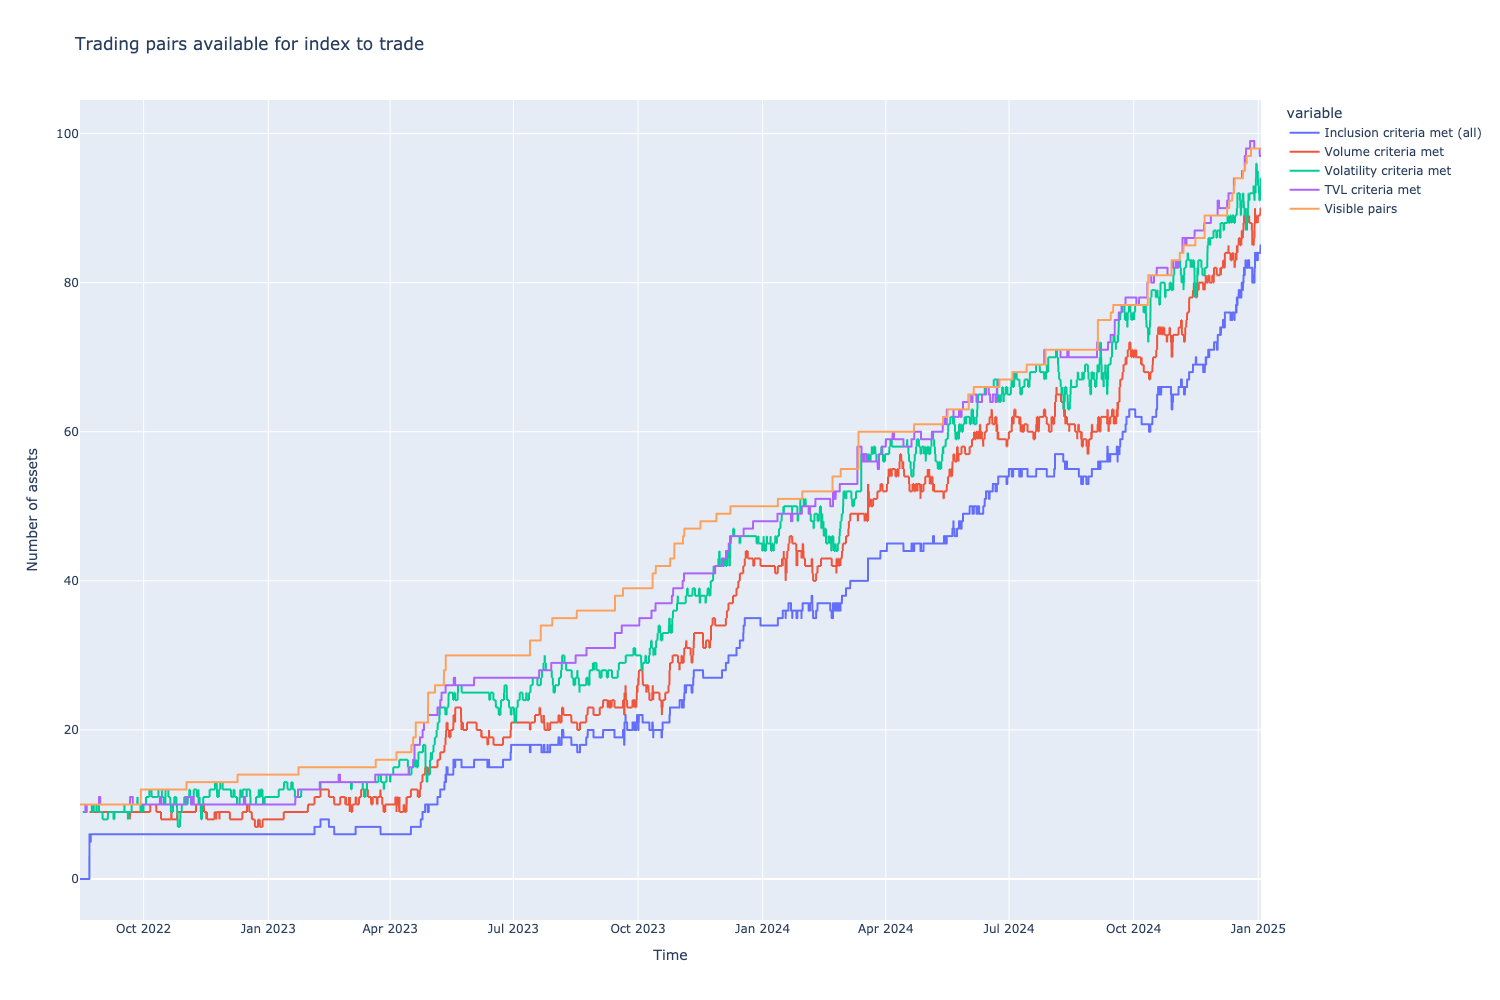

Inclusion criteria met (all)  Volume criteria met  \
2025-01-02 20:00:00                            85                 90.0   
2025-01-02 21:00:00                            85                 90.0   
2025-01-02 22:00:00                            85                 90.0   
2025-01-02 23:00:00                            85                 90.0   
2025-01-03 00:00:00                            85                 90.0   

                     Volatility criteria met  TVL criteria met  Visible pairs  
2025-01-02 20:00:00                     94.0                97             98  
2025-01-02 21:00:00                     94.0                97             98  
2025-01-02 22:00:00                     94.0                97             98  
2025-01-02 23:00:00                     94.0                97             98  
2025-01-03 00:00:00                     94.0                97             98

In [6]:
import plotly.express as px

df = pd.DataFrame({
    "Inclusion criteria met (all)": indicator_data.get_indicator_series("all_criteria_included_pair_count"),
    "Volume criteria met": indicator_data.get_indicator_series("volume_included_pair_count"),
    "Volatility criteria met": indicator_data.get_indicator_series("volatility_included_pair_count"),
    "TVL criteria met": indicator_data.get_indicator_series("tvl_included_pair_count"),
    "Visible pairs": indicator_data.get_indicator_series("trading_pair_count"),
})

fig = px.line(df, title='Trading pairs available for index to trade')
fig.update_yaxes(title="Number of assets")
fig.update_xaxes(title="Time")
fig.show()

display(df.tail(5))

Find the first availability, or admission to index, of all trading pairs.

In [7]:
series = indicator_data.get_indicator_series("inclusion_criteria")

exploded = series.explode()
first_appearance_series = exploded.groupby(exploded.values).apply(lambda x: x.index[0])

df = pd.DataFrame({
    "Included at": first_appearance_series
})

df["Ticker"] = first_appearance_series.index.map(lambda pair_id: strategy_universe.get_pair_by_id(pair_id).get_ticker())
df["DEX"] = first_appearance_series.index.map(lambda pair_id: strategy_universe.get_pair_by_id(pair_id).exchange_name)
df = df.sort_values("Included at")

def _map_tvl(row):
    pair_id = row.name  # Indxe
    timestamp = row["Included at"]
    tvl, delay = strategy_universe.data_universe.liquidity.get_liquidity_with_tolerance(
        pair_id,
        timestamp,
        tolerance=pd.Timedelta(days=2),
    )
    return tvl

# Get the first entry and value of rolling cum volume of each pair
volume_series = indicator_data.get_indicator_data_pairs_combined("rolling_cumulative_volume")
first_volume_df = volume_series.reset_index().groupby("pair_id").first()

def _map_volume_timestamp(row):
    pair_id = row.name  # Index
    try:
        return first_volume_df.loc[pair_id]["timestamp"]
    except KeyError:
        return None
    
def _map_volume_value(row):
    pair_id = row.name  # Index
    try:
        return first_volume_df.loc[pair_id]["value"]
    except KeyError:
        return None

df["TVL at inclusion"] = df.apply(_map_tvl, axis=1)
df["Rolling volume first entry at"] = df.apply(_map_volume_timestamp, axis=1)
df["Rolling volume initial"] = df.apply(_map_volume_value, axis=1)

print(f"First appearances of {len(df)} trading pairs, when they meet all inclusion criteria:")

with pd.option_context("display.float_format", "{:,.2f}".format):
    display(df)


First appearances of 92 trading pairs, when they meet all inclusion criteria:


Included at          Ticker         DEX  TVL at inclusion  \
7717    2022-08-21 23:00:00      LEASH-WETH  uniswap-v2        288,670.11   
37316   2022-08-21 23:00:00       ELON-WETH  uniswap-v2     12,066,279.63   
68900   2022-08-21 23:00:00      FLOKI-WETH  uniswap-v2      2,749,733.48   
83008   2022-08-21 23:00:00      TSUKA-USDC  uniswap-v2      1,267,184.68   
2697640 2022-08-21 23:00:00       SHIB-WETH  uniswap-v3      1,213,847.38   
2701164 2022-08-21 23:00:00       BONE-WETH  uniswap-v3         46,607.28   
2833961 2023-02-04 03:00:00     KIBSHI-WETH  uniswap-v2         42,199.13   
2785201 2023-02-08 13:00:00      LMEOW-WETH  uniswap-v2         37,794.81   
3010484 2023-04-23 15:00:00       PEPE-WETH  uniswap-v2      3,388,108.76   
3015124 2023-04-24 23:00:00      WOJAK-WETH  uniswap-v2        689,871.53   
3018875 2023-04-26 21:00:00        BOB-WETH  uniswap-v2        375,012.96   
3038307 2023-05-06 00:00:00   pepecoin-WETH  uniswap-v2      1,017,782.22   
3033402 2023-05-08 01:00:00      $MONG-WETH  uniswap-v2      2,227,434.06   
3047249 2023-05-11 02:00:00      TURBO-WETH  uniswap-v3         29,609.79   
3031971 2023-05-12 08:00:00      JESUS-WETH  uniswap-v2        123,823.04   
3026347 2023-05-12 15:00:00       OSAK-WETH  uniswap-v2        719,102.48   
3061151 2023-05-17 16:00:00      LADYS-WETH  uniswap-v2      2,032,345.29   
3073705 2023-05-19 03:00:00       BOBO-WETH  uniswap-v2        137,460.59   
3073784 2023-06-02 00:00:00    BITCOIN-WETH  uniswap-v3         47,657.85   
3054571 2023-06-29 00:00:00        BAD-WETH  uniswap-v2        978,346.57   
3226046 2023-07-28 04:00:00        Mog-WETH  uniswap-v2        578,237.56   
3242770 2023-08-05 16:00:00        NPC-WETH  uniswap-v2         95,959.61   
3271833 2023-08-23 19:00:00        SPX-WETH  uniswap-v2        211,915.12   
3311668 2023-09-21 00:00:00   шайлушай-WETH  uniswap-v2        261,582.32   
3308171 2023-09-21 20:00:00       PSPS-WETH  uniswap-v2         51,164.49   
3319606 2023-09-26 22:00:00        APX-WETH  uniswap-v2        267,130.50   
3347784 2023-10-18 19:00:00        JOE-WETH  uniswap-v2        342,708.41   
3361302 2023-10-31 18:00:00       BCAT-WETH  uniswap-v2        177,103.55   
3367917 2023-11-03 19:00:00      Kekec-WETH  uniswap-v2        237,122.38   
3376429 2023-11-10 06:00:00       MEME-WETH  uniswap-v3        149,476.72   
3377643 2023-11-11 04:00:00       GROK-WETH  uniswap-v2      1,029,047.13   
3402904 2023-12-02 00:00:00       Bonk-WETH  uniswap-v3         44,112.78   
3430630 2023-12-04 21:00:00        ZYN-WETH  uniswap-v2        201,604.88   
3365484 2023-12-12 19:00:00        DOG-WETH  uniswap-v3      3,707,325.32   
3445245 2023-12-15 05:00:00       BYTE-WETH  uniswap-v2        367,269.63   
2894712 2023-12-18 00:00:00    OPTIMUS-WETH  uniswap-v2      1,317,300.83   
3484249 2024-01-12 07:00:00    PEPE2.0-WETH  uniswap-v2      1,044,686.25   
3017331 2024-01-20 02:00:00      TROLL-WETH  uniswap-v2      2,451,166.61   
3523948 2024-02-06 06:00:00       PORK-WETH  uniswap-v3     13,891,665.13   
3552847 2024-02-28 14:00:00      Kendu-WETH  uniswap-v2         84,011.00   
3350536 2024-03-05 17:00:00       NATI-WETH  uniswap-v2        661,226.47   
3573307 2024-03-18 19:00:00       ANDY-WETH  uniswap-v2        113,318.16   
3563618 2024-03-18 19:00:00     STRUMP-WETH  uniswap-v2        965,653.72   
3576318 2024-03-18 19:00:00        APU-WETH  uniswap-v2        768,190.15   
3574910 2024-03-28 00:00:00      HOPPY-WETH  uniswap-v2         48,879.62   
3574627 2024-04-01 19:00:00    BIRDDOG-WETH  uniswap-v2        211,878.82   
3634091 2024-04-28 20:00:00       WOLF-WETH  uniswap-v2        389,101.20   
3213475 2024-05-05 21:00:00      BRETT-WETH  uniswap-v2         70,884.11   
2734754 2024-05-14 00:00:00      $ROAR-WETH  uniswap-v2         30,903.68   
3656844 2024-05-20 04:00:00        GME-WETH  uniswap-v2        497,634.99   
3660572 2024-05-23 14:00:00       MAGA-WETH  uniswap-v2      1,148,641.40   
3675389 2024

In [8]:
# ts = pd.Timestamp("2024-02-14 02:00:00")
# series = indicator_data.get_indicator_data_pairs_combined("tvl")
# display(series.loc[(4572399, ts)])

# #display(series)
# mask = series >= Parameters.min_tvl
# # Turn to a series of lists
# mask_true_values_only = mask[mask == True]
# display(mask_true_values_only)
# series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())


# #display(mask.reset_index().groupby("timestamp"))
# #display(mask[(4572399, ts)])
# display(series[ts])
# display(series)


# Price vs. signal

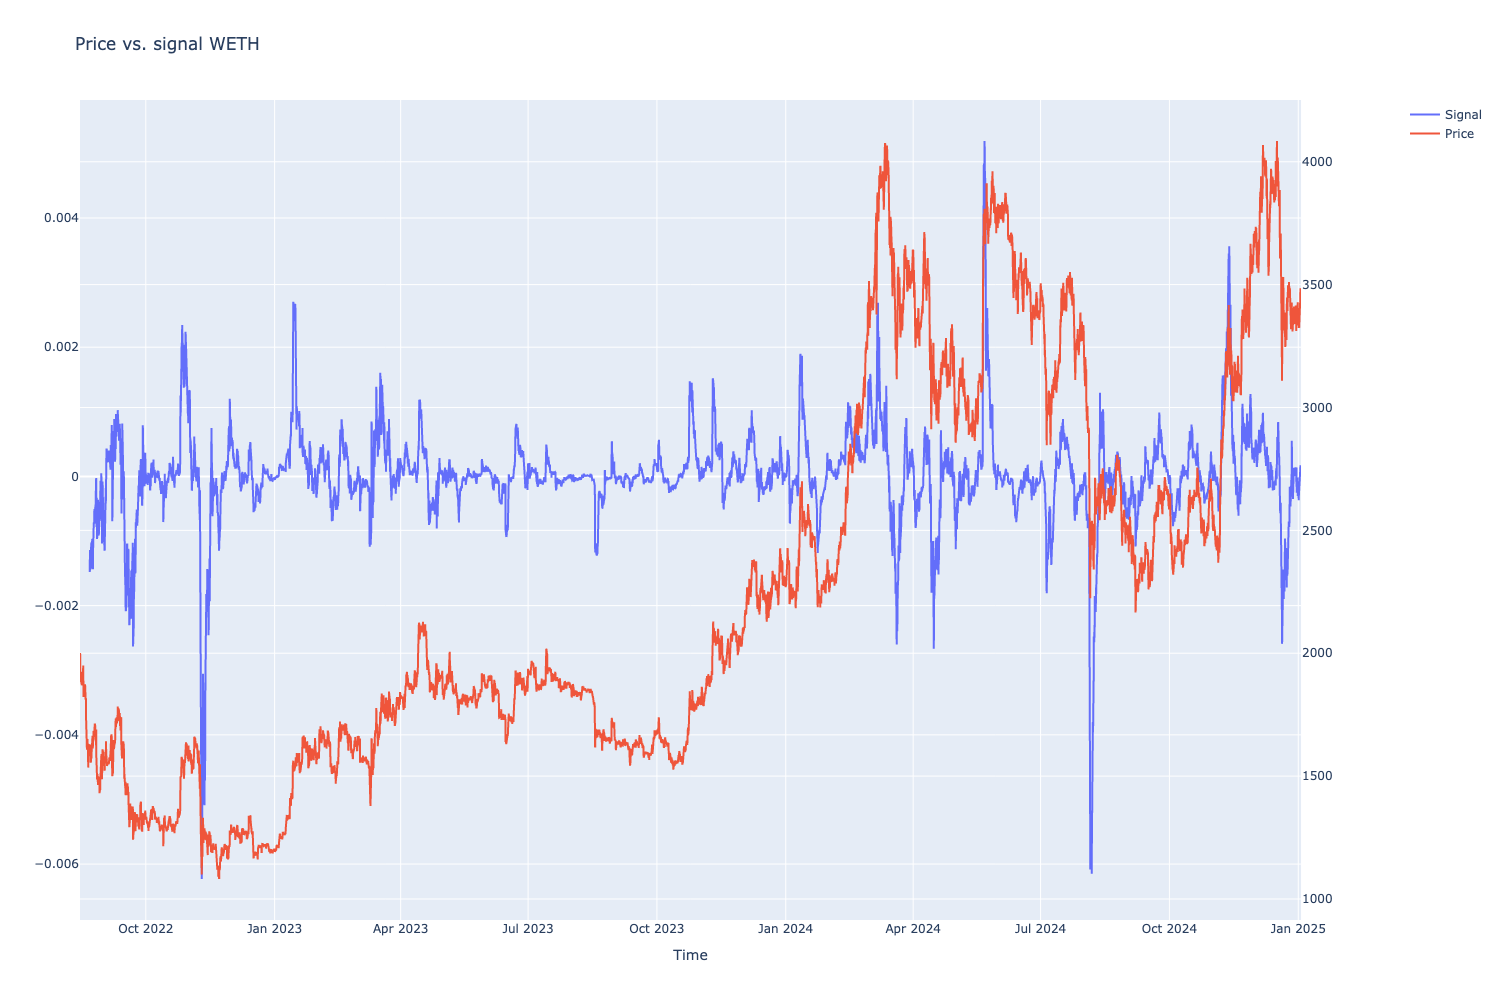

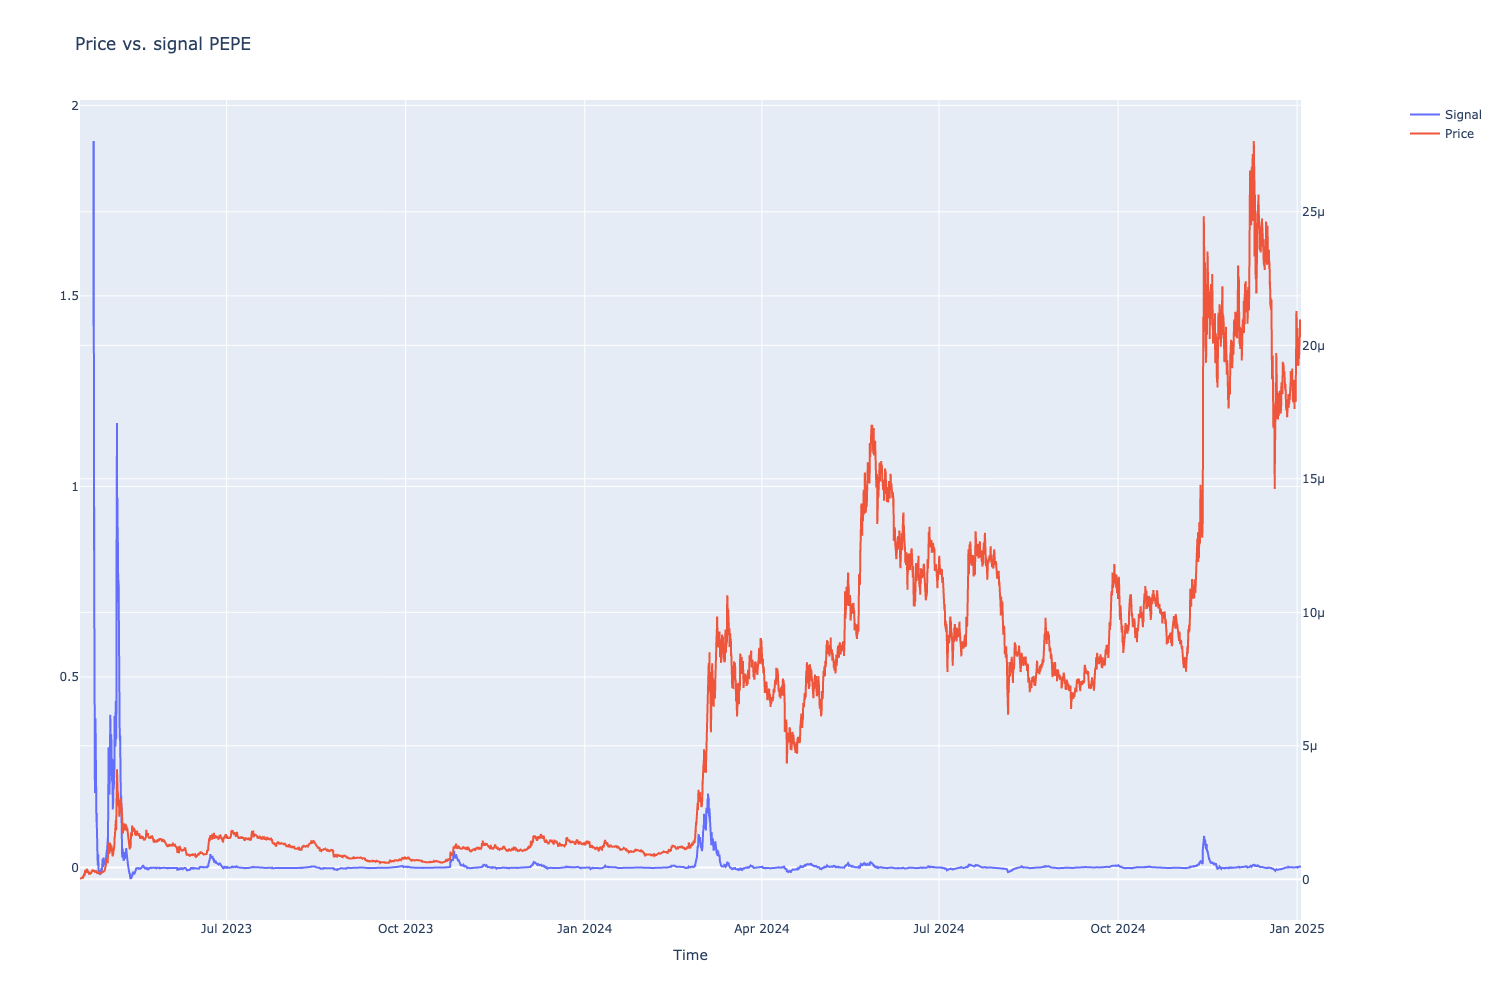

In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = [
    "WETH", 
    "PEPE"
]

# TODO: Plotly refuses correctly to plot the third y-axis
for symbol in selected_assets:
    pair = token_map.get(symbol)
    price = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)["close"]
    signal = indicator_data.get_indicator_series("volatility_returns_indicator", pair=pair)    
    volatility = indicator_data.get_indicator_series("volatility", pair=pair)

    df = pd.DataFrame({
        "price": price,
        "signal": signal,
        # "volatility": volatility,
    })

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=df.index, y=df["signal"], name="Signal"),
        secondary_y=False,        
    )

    # fig.add_trace(
    #    go.Scatter(x=df.index, y=df["volatility"], name="Volatility", yaxis="y2"),
    #    secondary_y=True,
    #)

    fig.add_trace(
        go.Scatter(x=df.index, y=df["price"], name="Price", yaxis="y3"),
        secondary_y=True,        
    )

    fig.update_layout(title=f"Price vs. signal {symbol}")
    fig.update_layout(showlegend=True)
    fig.update_xaxes(title="Time")
    # fig.update_layout(
    #    yaxis_type="log"   
    #)
    

    fig.show()
    

# Price vs. volatility

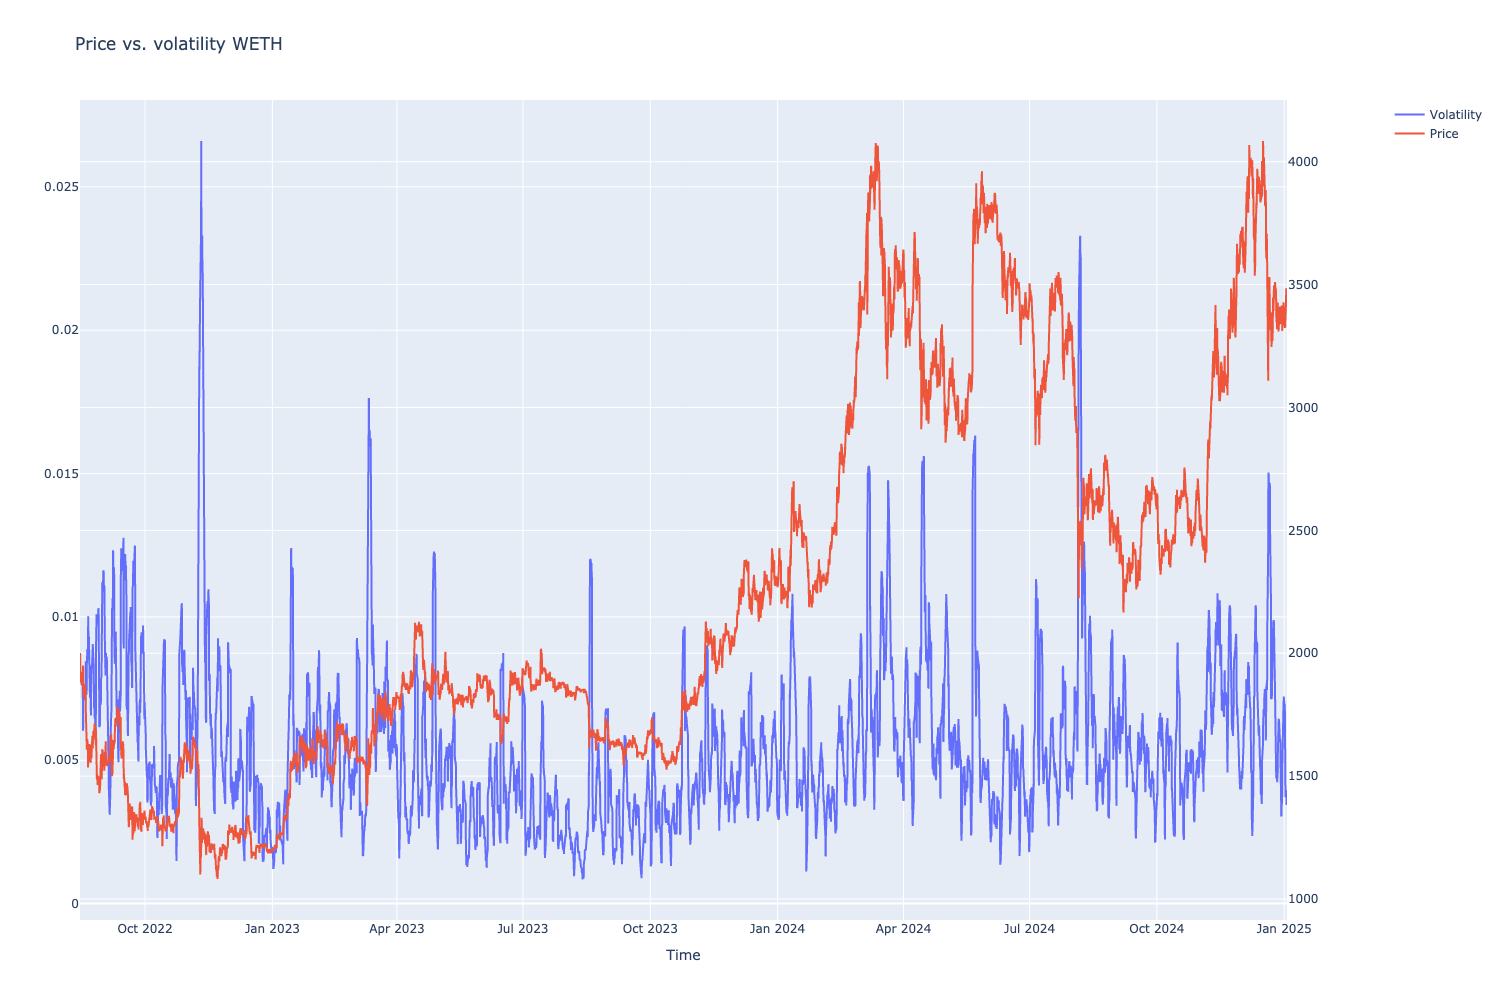

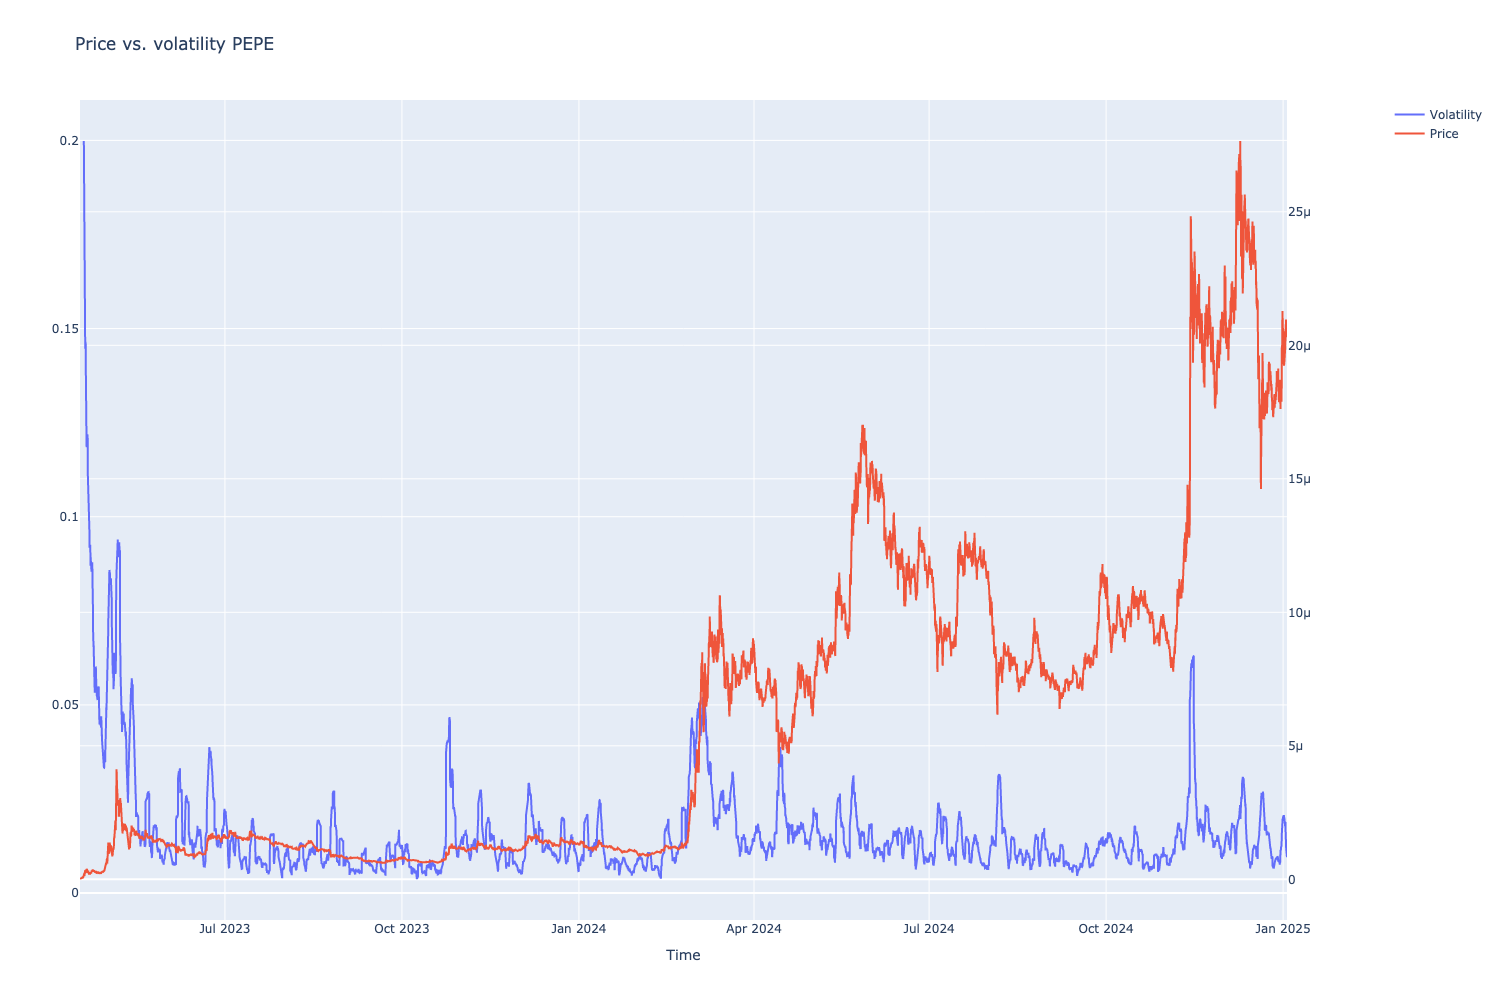

In [10]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = [
    "WETH", 
    "PEPE"
]

# TODO: Plotly refuses correctly to plot the third y-axis
for symbol in selected_assets:
    pair = token_map[symbol]
    price = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)["close"]
    signal = indicator_data.get_indicator_series("volatility_returns_indicator", pair=pair)    
    volatility = indicator_data.get_indicator_series("volatility", pair=pair)

    df = pd.DataFrame({
        "price": price,
        "signal": signal,
        "volatility": volatility,
    })

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=df.index, y=df["volatility"], name="Volatility"),
        secondary_y=False,        
    )

    # fig.add_trace(
    #    go.Scatter(x=df.index, y=df["volatility"], name="Volatility", yaxis="y2"),
    #    secondary_y=True,
    #)

    fig.add_trace(
        go.Scatter(x=df.index, y=df["price"], name="Price", yaxis="y3"),
        secondary_y=True,        
    )

    fig.update_layout(title=f"Price vs. volatility {symbol}")
    fig.update_layout(showlegend=True)
    fig.update_xaxes(title="Time")
    # fig.update_layout(
    #    yaxis_type="log"   
    #)
    

    fig.show()
    

# Backtest time range

- Choose the backtesting time range
- Start when we have enough assets (`Parameters.min_asset_universe`) in our asset universe to form the first basket

In [11]:
series = indicator_data.get_indicator_series("all_criteria_included_pair_count")

exceeds_threshold = series > Parameters.min_asset_universe
# Get the first date where the condition is True
backtest_start = exceeds_threshold[exceeds_threshold].first_valid_index()
backtest_end = series.index[-1]

print(f"Time range is {backtest_start} - {backtest_end}")

Time range is 2022-08-21 23:00:00 - 2025-01-03 00:00:00


# Strategy algorithm and backtest

- Run the backtest

In [12]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput, IndicatorDataNotFoundWithinDataTolerance
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.tvl_size_risk import USDTVLSizeRiskModel
from tradeexecutor.strategy.weighting import weight_by_1_slash_n, weight_passthrouh, weight_equal
from tradeexecutor.utils.dedent import dedent_any

import heapq


def decide_trades(
    input: StrategyInput
) -> list[TradeExecution]:
    """For each strategy tick, generate the list of trades."""
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    # Build signals for each pair 
    alpha_model = AlphaModel(
        timestamp,
        close_position_weight_epsilon=parameters.min_portfolio_weight,  # 10 BPS is our min portfolio weight
    )

    # Prepare diagnostics variables
    max_vol = (0, None)  
    max_tvl = (0, None)  
    signal_count = 0  
    vol_pair = strategy_universe.get_pair_by_human_description(VOL_PAIR)
    volume_included_pair_count = indicators.get_indicator_value(
        "volume_included_pair_count",
    )
    volatility_included_pair_count = indicators.get_indicator_value(
        "volatility_included_pair_count",
    ) 
    tvl_included_pair_count = indicators.get_indicator_value(
        "tvl_included_pair_count",
    )
    
    # Get pairs included in this rebalance cycle.
    # This includes pair that have been pre-cleared in inclusion_criteria()
    # with volume, volatility and TVL filters 
    included_pairs = indicators.get_indicator_value(
        "inclusion_criteria",
        na_conversion=False,
    )
    if included_pairs is None:
        included_pairs = []

    clipped_pairs = 0

    # Set signal for each pair
    for pair_id in included_pairs:
        pair = strategy_universe.get_pair_by_id(pair_id)

        signal = indicators.get_indicator_value("tvl", pair=pair)
        
        if signal is None or signal < 0:
            # No data yet or
            # negatir returns
            continue

        weight = signal

        alpha_model.set_signal(
            pair,
            weight,
        )

        # Diagnostics reporting
        signal_count += 1


    # Calculate how much dollar value we want each individual position to be on this strategy cycle,
    # based on our total available equity
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation

    # Select max_assets_in_portfolio assets in which we are going to invest
    # Calculate a weight for ecah asset in the portfolio using 1/N method based on the raw signal
    # alpha_model.select_top_signals(count=parameters.max_assets_in_portfolio)
    count = parameters.max_assets_in_portfolio
    top_signals = sorted(list(alpha_model.raw_signals.values()), key=lambda s: s.signal, reverse=True)[0:count]
    alpha_model.signals = {s.pair.internal_id: s for s in top_signals}

    if timestamp == pd.Timestamp("2025-01-02 00:00:00"):
        for s in alpha_model.raw_signals.values():
            print(s.pair, s.signal)

    alpha_model.assign_weights(method=weight_equal)
    # alpha_model.assign_weights(method=weight_by_1_slash_n)

    #
    # Normalise weights and cap the positions
    # 
    size_risk_model = USDTVLSizeRiskModel(
        pricing_model=input.pricing_model,
        per_position_cap=parameters.per_position_cap_of_pool,  # This is how much % by all pool TVL we can allocate for a position
        missing_tvl_placeholder_usd=parameters.assummed_liquidity_when_data_missings,  # Placeholder for missing TVL data until we get the data off the chain
    )

    alpha_model.normalise_weights(
        investable_equity=portfolio_target_value,
        size_risk_model=size_risk_model,
        max_weight=parameters.max_concentration,
    )

    # Load in old weight for each trading pair signal,
    # so we can calculate the adjustment trade size
    alpha_model.update_old_weights(
        state.portfolio,
        ignore_credit=True,
    )
    alpha_model.calculate_target_positions(position_manager)

    # Shift portfolio from current positions to target positions
    # determined by the alpha signals (momentum)
    
    # rebalance_threshold_usd = portfolio_target_value * parameters.min_rebalance_trade_threshold_pct
    rebalance_threshold_usd = parameters.individual_rebalance_min_threshold_usd
    
    assert rebalance_threshold_usd > 0.1, "Safety check tripped - something like wrong with strat code"
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=rebalance_threshold_usd,  # Don't bother with trades under XXXX USD
        invidiual_rebalance_min_threshold=parameters.individual_rebalance_min_threshold_usd,
        execution_context=input.execution_context,
    )

    # Add verbal report about decision made/not made,
    # so it is much easier to diagnose live trade execution.
    # This will be readable in Discord/Telegram logging.
    if input.is_visualisation_enabled():
        try:
            top_signal = next(iter(alpha_model.get_signals_sorted_by_weight()))
            if top_signal.normalised_weight == 0:
                top_signal = None
        except StopIteration:
            top_signal = None

        max_vol_pair = max_vol[1]
        if max_vol_pair:
            max_vol_signal = alpha_model.get_signal_by_pair(max_vol_pair)
        else:
            max_vol_signal = None

        vol_pair_vol = indicators.get_indicator_value("volatility_ewm", pair=vol_pair)

        rebalance_volume = sum(t.get_value() for t in trades)
        
        report = dedent_any(f"""
        Cycle: #{input.cycle}
        Rebalanced: {'👍' if alpha_model.is_rebalance_triggered() else '👎'}
        Open/about to open positions: {len(state.portfolio.open_positions)} 
        Max position value change: {alpha_model.max_position_adjust_usd:,.2f} USD
        Rebalance threshold: {alpha_model.position_adjust_threshold_usd:,.2f} USD
        Trades decided: {len(trades)}
        Pairs total: {strategy_universe.data_universe.pairs.get_count()}
        Pairs meeting inclusion criteria: {len(included_pairs)}
        Pairs meeting volume inclusion criteria: {volume_included_pair_count}
        Pairs meeting volatility inclusion criteria: {volatility_included_pair_count}        
        Pairs meeting TVL inclusion criteria: {tvl_included_pair_count}        
        Pairs under volatility threshold: {clipped_pairs}        
        Signals created: {signal_count}
        Total equity: {portfolio.get_total_equity():,.2f} USD
        Cash: {position_manager.get_current_cash():,.2f} USD
        Investable equity: {alpha_model.investable_equity:,.2f} USD
        Accepted investable equity: {alpha_model.accepted_investable_equity:,.2f} USD
        Allocated to signals: {alpha_model.get_allocated_value():,.2f} USD
        Discarted allocation because of lack of lit liquidity: {alpha_model.size_risk_discarded_value:,.2f} USD
        Rebalance volume: {rebalance_volume:,.2f} USD
        {vol_pair.base.token_symbol} volatility: {vol_pair_vol}        
        Most volatility pair: {max_vol_pair.get_ticker() if max_vol_pair else '-'}
        Most volatility pair vol: {max_vol[0]}
        Most volatility pair signal value: {max_vol_signal.signal if max_vol_signal else '-'}
        Most volatility pair signal weight: {max_vol_signal.raw_weight if max_vol_signal else '-'}        
        """)

        # Most volatility pair signal weight (normalised): {max_vol_signal.normalised_weight * 100 if max_vol_signal else '-'} % (got {max_vol_signal.position_size_risk.get_relative_capped_amount() * 100 if max_vol_signal else '-'} % of asked size)
        if top_signal:
            top_signal_vol = indicators.get_indicator_value("volatility_ewm", pair=top_signal.pair)
            assert top_signal.position_size_risk
            report += dedent_any(f"""
            Top signal pair: {top_signal.pair.get_ticker()}
            Top signal volatility: {top_signal_vol}
            Top signal value: {top_signal.signal}
            Top signal TVL: {top_signal.get_tvl()}
            Top signal weight: {top_signal.raw_weight}
            Top signal weight (normalised): {top_signal.normalised_weight * 100:.2f} % (got {top_signal.position_size_risk.get_relative_capped_amount() * 100:.2f} % of asked size)
            """)            

        for index, top_signal in enumerate(top_signals, start=1):
            report += dedent_any(f"""
            Top singal #{index}
            Top signal pair: {top_signal.pair.get_ticker()}
            Top signal volatility: {top_signal_vol}
            Top signal value: {top_signal.signal}
            Top signal TVL: {top_signal.get_tvl()}
            Top signal weight: {top_signal.raw_weight}
            Top signal weight (normalised): {top_signal.normalised_weight * 100:.2f} % (got {top_signal.position_size_risk.get_relative_capped_amount() * 100:.2f} % of asked size)
            """)            

        for flag, count in alpha_model.get_flag_diagnostics_data().items():
            report += f"Signals with flag {flag.name}: {count}\n"

        state.visualisation.add_message(
            timestamp,
            report, 
        )

        state.visualisation.set_discardable_data("alpha_model", alpha_model)

    return trades  # Return the list of trades we made in this cycle


result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=indicators.create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    # log_level=logging.INFO,
    max_workers=1,
    start_at=backtest_start.to_pydatetime(),
    end_at=backtest_end.to_pydatetime(),
)

state = result.state

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Reading cached indicators trailing_sharpe, trailing_sharpe_ewm, volatility, signed_volatility, rolling_returns…

Using indicator cache /Users/moo/.cache/indicators/ethereum_1h_103_2022-08-15-2025-01-03_ff


  0%|          | 0/74739600 [00:00<?, ?it/s]

<Pair MSTR-WETH spot_market_hold at 0x318ba85ca49a3b12d3cf9c72cc72b29316971802 (0.3000% fee) on exchange uniswap-v2> 1182502.375310766
<Pair NPC-WETH spot_market_hold at 0x69c7bd26512f52bf6f76fab834140d13dda673ca (0.3000% fee) on exchange uniswap-v2> 4598385.980281923
<Pair NEIRO-WETH spot_market_hold at 0x3885fbe4cd8aed7b7e9625923927fa1ce30662a3 (0.3000% fee) on exchange uniswap-v2> 11485648.81412557
<Pair BCAT-WETH spot_market_hold at 0x0afd65ec6b286d353c42268738d66bbf56ba9de5 (0.3000% fee) on exchange uniswap-v2> 524221.21383706515
<Pair FIGHT-WETH spot_market_hold at 0x63a151d042dc870fb1b3f0c72cbbdd53a85898f6 (0.3000% fee) on exchange uniswap-v2> 638140.2366283734
<Pair MAGA-WETH spot_market_hold at 0x0c3fdf9c70835f9be9db9585ecb6a1ee3f20a6c7 (0.3000% fee) on exchange uniswap-v2> 2493249.1000451082
<Pair MOON-WETH spot_market_hold at 0x13dc1cb588dad95370b75065692bf33a3dba9f1c (0.3000% fee) on exchange uniswap-v2> 1677824.695673284
<Pair FLOKI-WETH spot_market_hold at 0xca7c2771d248d

# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

**Note**: Some of these metrics might be incorrect due to slow start of the strategy

In [13]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

compare_strategy_backtest_to_multiple_assets(
    state,
    strategy_universe,
    display=True,
    interesting_assets=["WETH", "KEYCAT", "ANDY"],
)

Strategy                  ETH  \
Start Period                        2022-08-21           2022-08-21   
End Period                          2025-01-02           2025-01-02   
Risk-Free Rate                            0.0%                 0.0%   
Time in Market                          100.0%               100.0%   
Cumulative Return                    1,272.56%              110.41%   
CAGR﹪                                  114.48%                24.2%   
Sharpe                                    1.35                 0.82   
Prob. Sharpe Ratio                      99.51%               89.83%   
Smart Sharpe                              1.23                 0.75   
Sortino                                   2.83                 1.24   
Smart Sortino                             2.57                 1.13   
Sortino/√2                                 2.0                 0.88   
Smart Sortino/√2                          1.82                  0.8   
Omega                                     1.27                 1.27   
Max Drawdown                            -71.2%              -44.99%   
Longest DD Days                            302                  296   
Volatility (ann.)                       144.5%               60.01%   
Calmar                                    1.61                 0.54   
Skew                                      7.13                 0.35   
Kurtosis                                121.27                  4.5   
Expected Daily                            0.3%                0.09%   
Expected Monthly                         9.12%                2.51%   
Expected Yearly                         92.48%               20.44%   
Kelly Criterion                         10.53%                6.59%   
Risk of Ruin                              0.0%                 0.0%   
Daily Value-at-Risk                    -11.91%               -5.03%   
Expected Shortfall (cVaR)              -11.91%               -5.03%   
Max Consecutive Wins                         9                    8   
Max Consecutive Losses                       7                    6   
Gain/Pain Ratio                           0.27                 0.13   
Gain/Pain (1M)                            1.97                 1.21   
Payoff Ratio                              1.28                 1.09   
Profit Factor                             1.27                 1.13   
Common Sense Ratio                        1.66                 1.35   
CPC Index                                 0.81                 0.63   
Tail Ratio                                1.31                 1.19   
Outlier Win Ratio                         4.05                 6.64   
Outlier Loss Ratio                        3.26                 4.98   
MTD                                      1.41%                 1.6%   
3M                                      35.92%               29.59%   
6M                                       1.39%               -1.49%   
YTD                                      1.41%                 1.6%   
1Y                                     129.54%               47.89%   
3Y (ann.)                              114.48%                24.2%   
5Y (ann.)                              114.48%                24.2%   
10Y (ann.)                             114.48%                24.2%   
All-time (ann.)                        114.48%                24.2%   
Best Day                               136.67%               20.18%   
Worst Day                              -16.54%              -15.64%   
Best Month                             178.19%               47.77%   
Worst Month                            -36.24%              -22.85%   
Best Year                              524.56%               92.07%   
Worst Year                              -1.89%              -25.62%   
Avg. Drawdown                          -17.39%               -9.29%   
Avg. Drawdown Days                          36                   39   
Recovery Factor                            6.5                

# Equity curve

- Equity curve shows how your strategy accrues value over time

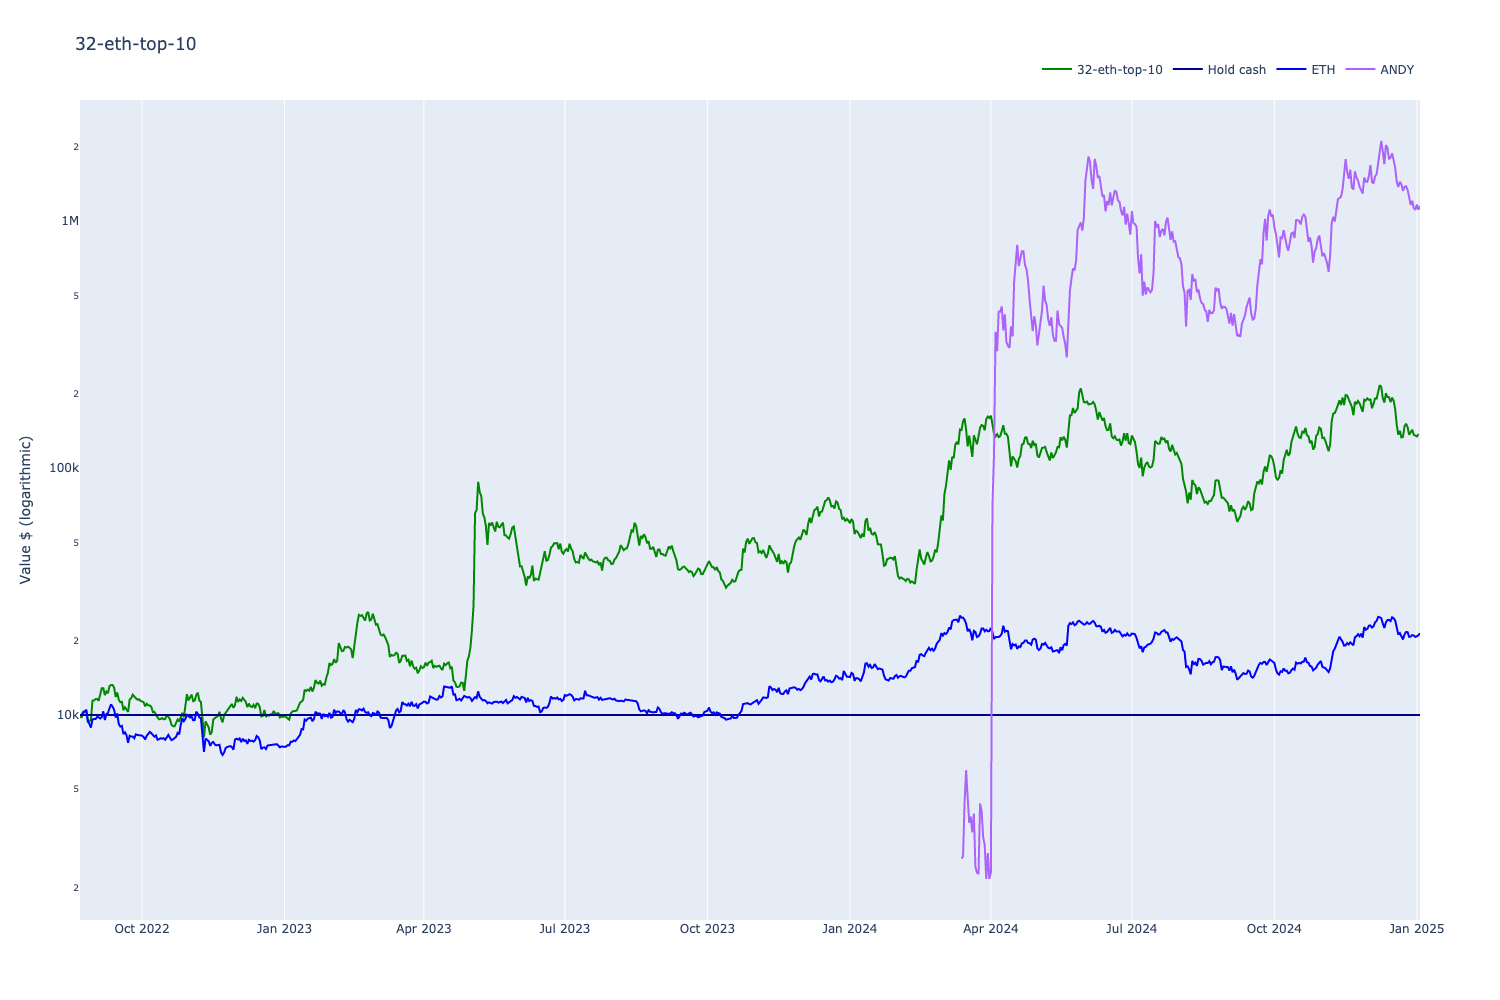

In [14]:
import pandas as pd
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=state.portfolio.get_initial_cash(),
    max_count=4,
    start_at=state.get_trading_time_range()[0],
    interesting_assets=["WETH", "ANDY", "weirdo"],
)

fig = visualise_equity_curve_benchmark(
    state=state,    
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=True,
)

fig.show()

## Equity curve with drawdown

- Linear curve

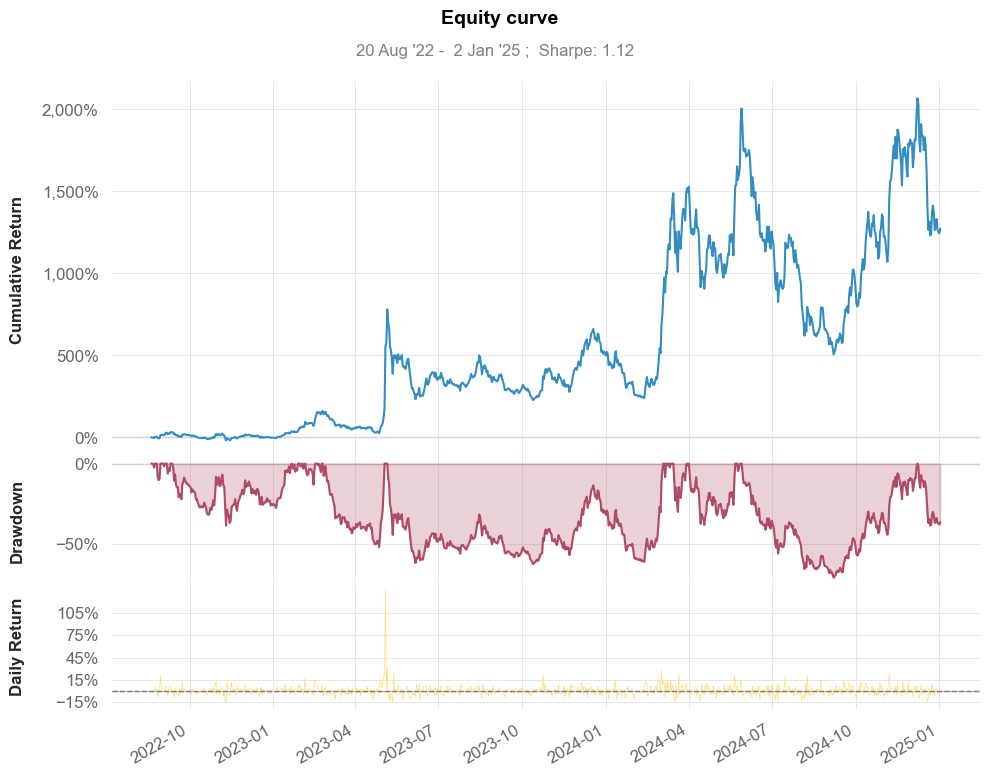

In [15]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
fig = visualise_equity_curve(returns)
display(fig)

# Asset weights

- What assets were allocated over time
- Do both proportional % and USD weights

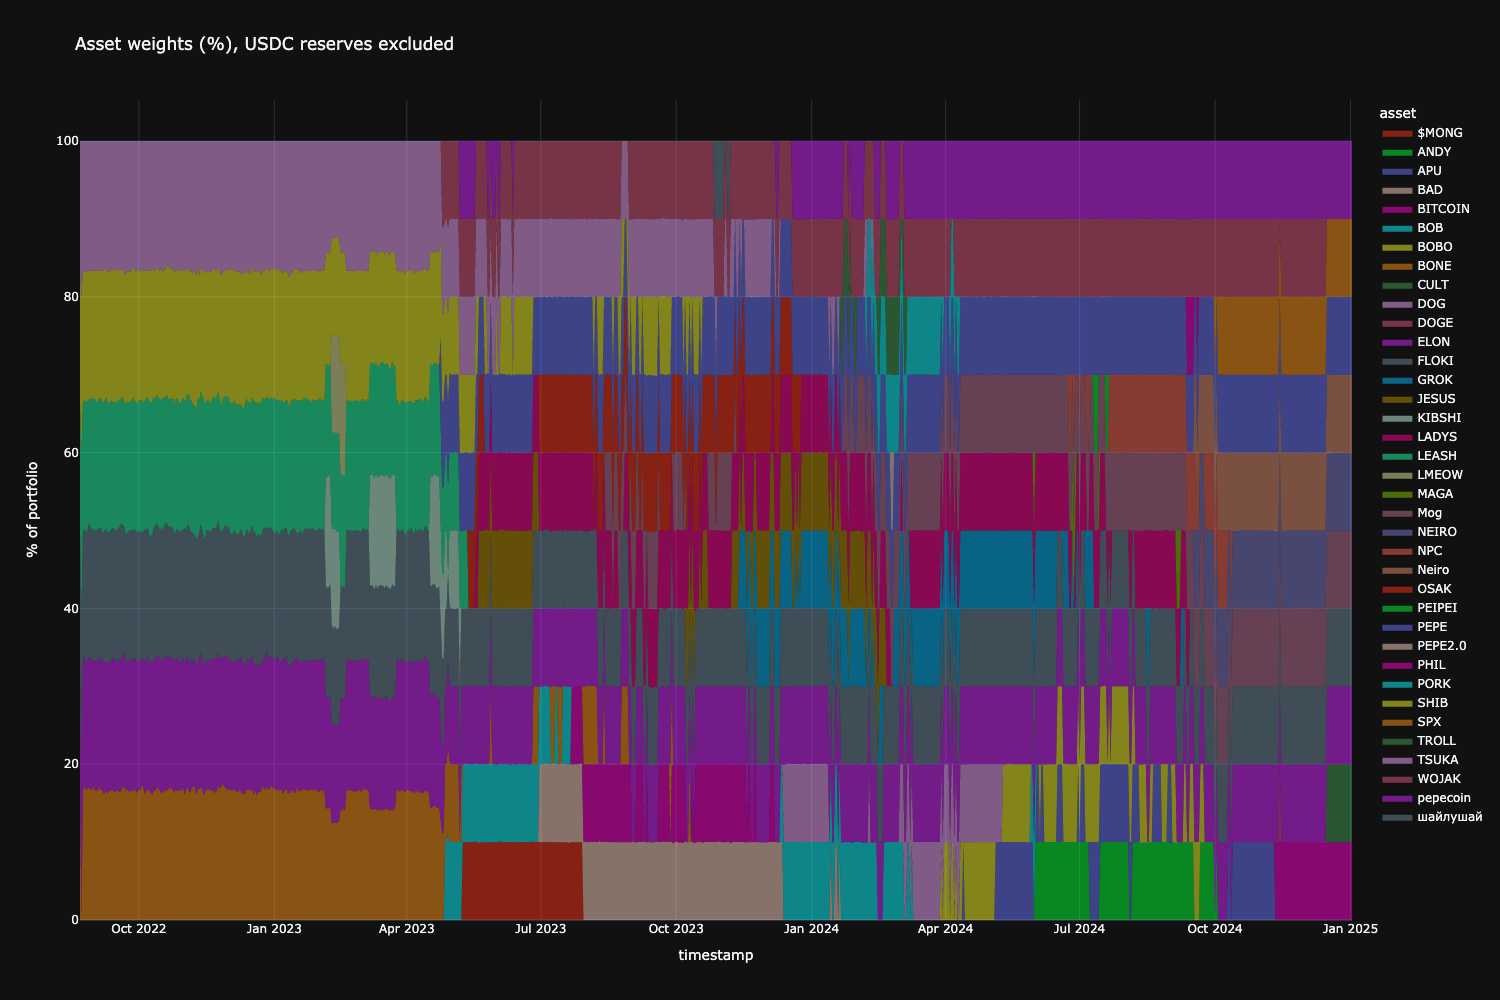

In [16]:
from tradeexecutor.analysis.weights import calculate_asset_weights, visualise_weights

weights_series = calculate_asset_weights(state)

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=False,
)
fig.show()

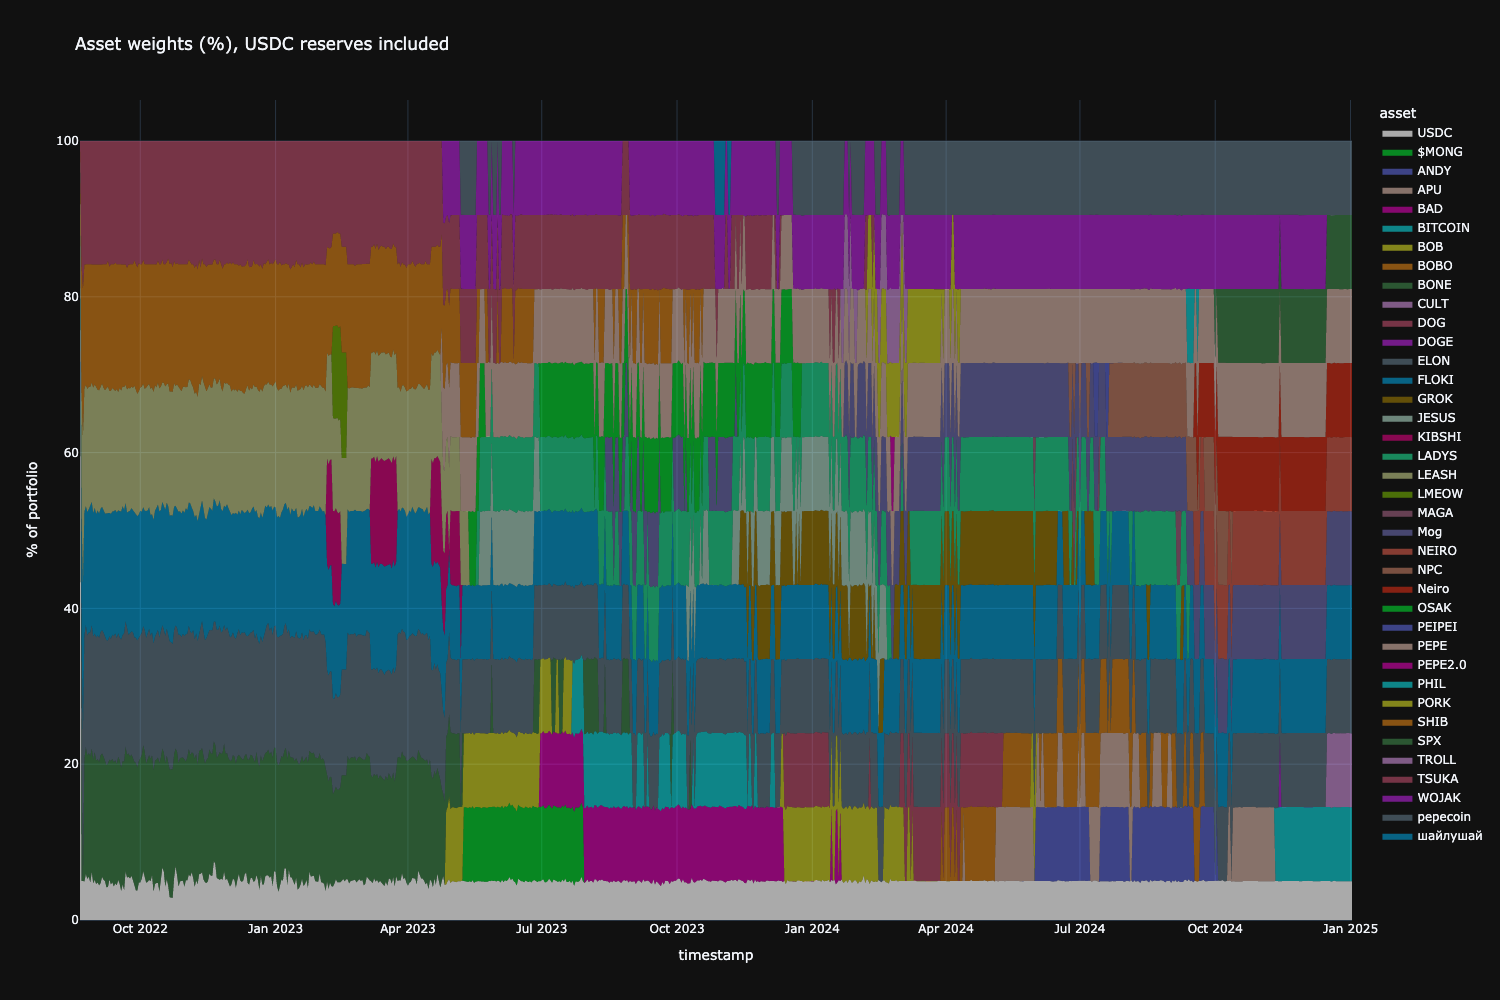

In [17]:

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=True,
)
fig.show()

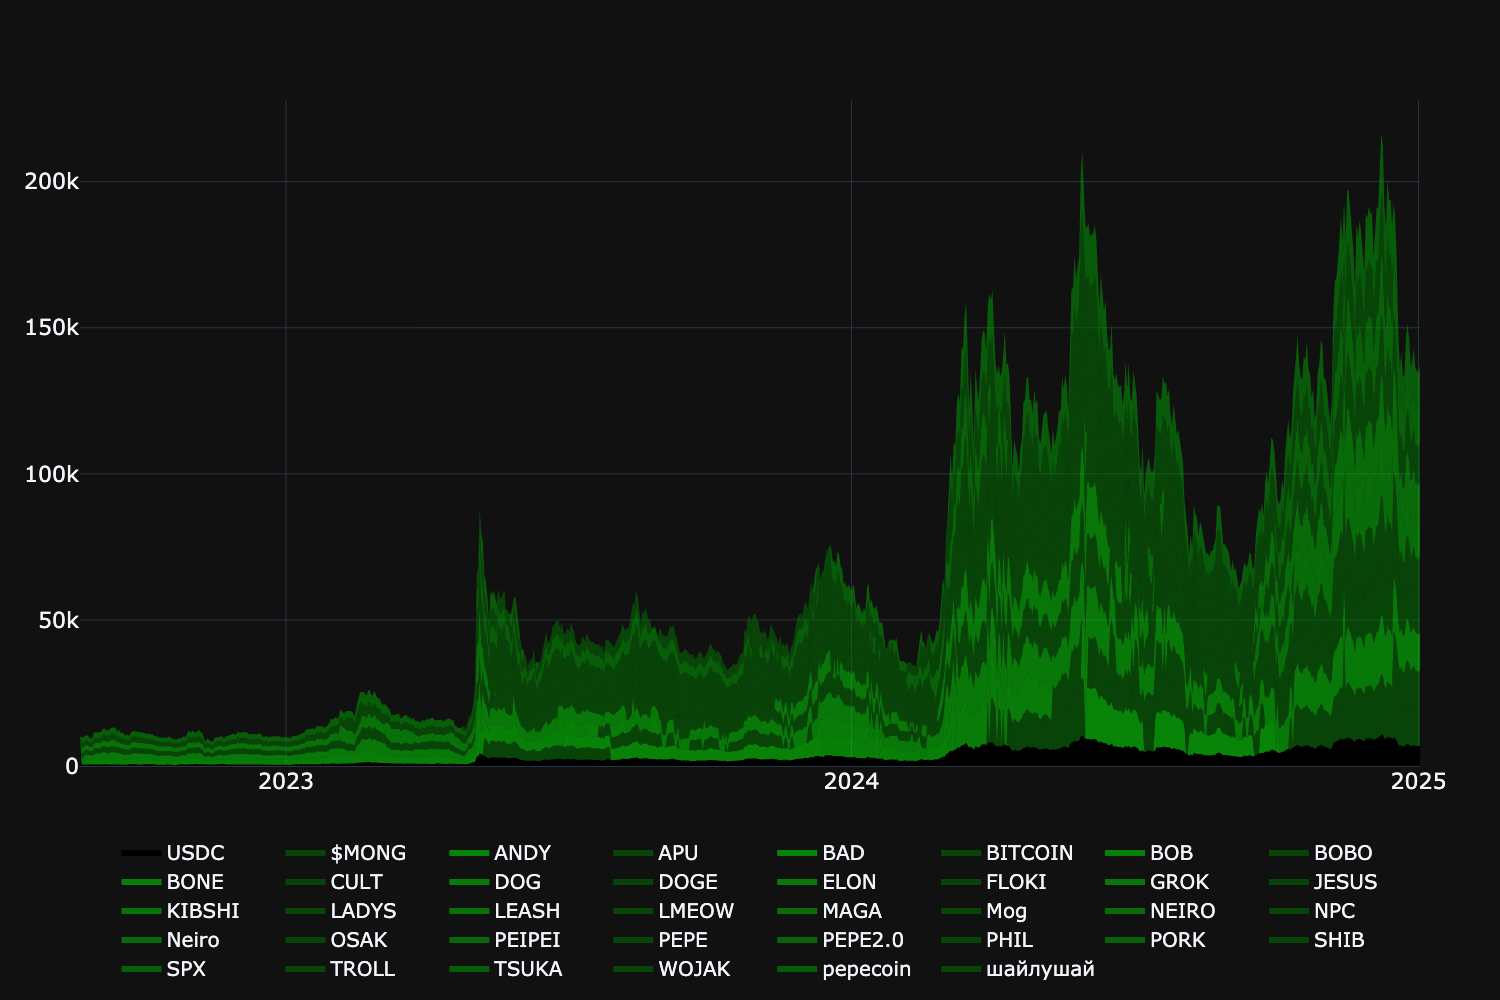

In [29]:
from tradeexecutor.analysis.weights import LegendMode 

df = weights_series.unstack(level=1)

def generate_sepia_palette(n=40):
    colors = []
    # Base sepia colors from light to dark
    sepia_base = [
        '#fff4e6',  # Very light sepia
        '#ffe4c4',  # Bisque
        '#deb887',  # Burlywood
        '#d2b48c',  # Tan
        '#bc8f8f',  # Rosy brown
        '#a0522d',  # Sienna
        '#8b4513',  # Saddle brown
        '#654321',  # Dark brown
    ]
    
    # Create variations by interpolating between base colors
    from matplotlib.colors import LinearSegmentedColormap, to_hex
    import numpy as np
    
    # Create a colormap from our sepia colors
    sepia_cmap = LinearSegmentedColormap.from_list('sepia', sepia_base)
    
    # Generate n colors
    values = np.linspace(0, 1, n)
    colors = [to_hex(sepia_cmap(v)) for v in values]
    
    return colors


def hacker_crt_green_palette(num_colors):
    """
    Generates a Plotly color palette in hacker CRT green style with varying brightness.
    
    Parameters:
    num_colors (int): Number of colors to generate.
    
    Returns:
    list: A list of color strings in hexadecimal format.
    """
    palette = []
    
    for i in range(num_colors):
        if i % 2 == 0:
            # Brighter green with varying intensity
            intensity = 255 - int((i / num_colors) * 100)  # Adjust intensity based on position
            brighter_green = f"#00{intensity:02X}00"
            palette.append(brighter_green)
        else:
            # Darker green (fixed for contrast)
            darker_green = "#007700"
            palette.append(darker_green)
    
    return palette


palette = hacker_crt_green_palette(40)


fig = visualise_weights(
    weights_series,
    normalised=False,
    legend_mode=LegendMode.bottom,
    color_palette=palette,
    reserve_asset_colour="black",
)

num_columns = 10
fig.update_layout(
    # Move legend to bottom
    legend=dict(
        yanchor="top",
        y=-0.1,  # Adjust this value to move legend up/down
        xanchor="center",
        x=0.5,
        # Arrange items in 4 rows
        orientation="h",
        traceorder="normal",
        # nrows=4
        itemwidth=40,  # Adjust the multiplier as needed
        title_text="",
        font=dict(
            size=20  # Adjust this value to make legend text bigger/smaller
        ),        
    )
)

fig.update_layout(
    title=None,
    xaxis=dict(
        title=None,
        # other x-axis properties...
        nticks=4,
        # Increase font size (default is usually 12)
        tickfont=dict(
            size=22  # Adjust this value to make font bigger/smaller
        )        
    ),
    yaxis=dict(
        title=None,
        # other y-axis properties...
        nticks=5,
        # Optionally specify tick labels
        # ticktext=['0%', '50%', '100%'],
        tickfont=dict(
            size=22,
        ),
                
    )
)

# Adjust figure size to make it more portrait-like
fig.update_layout(
    autosize=False,
    width=200,  # Decrease width
    height=200,  # Increase height for portrait aspect
    scene=dict(
        aspectratio=dict(x=0.5, y=1, z=0.5),  # Adjust x and y to change the aspect
        aspectmode='manual'
    )    
)


fig.show()

## Weight allocation statistics



In [19]:
from tradeexecutor.analysis.weights import calculate_weights_statistics

stats = calculate_weights_statistics(weights_series)
display(stats)


At     Pair      Value Unit
Name                                                                        
Max position (excluding USDC)   2024-12-08 00:00:00     PEPE  20,581.98  USD
Min position (excluding USDC)   2023-04-27 00:00:00      BOB   1,182.91  USD
Mean position (excluding USDC)                                 7,094.44  USD
Max position (excluding USDC)   2022-08-23 00:00:00    FLOKI      20.00    %
Min position (excluding USDC)   2023-09-19 00:00:00  BITCOIN       9.78    %
Mean position (excluding USDC)                                    11.22    %
Max position (including USDC)   2022-08-21 00:00:00     USDC     100.00    %
Min position (including USDC)   2022-10-23 00:00:00     USDC       2.84    %
Mean position (including USDC)                                    10.10    %

# Positions at the end

Some example positions at the end


In [20]:

for p in list(state.portfolio.open_positions.values())[0:10]:
    print(f"Position {p.pair.base.token_symbol}, value {p.get_value()} USD")

Position ELON, value 13045.218869928109 USD
Position FLOKI, value 13041.988848447607 USD
Position PEPE, value 13039.586791280844 USD
Position Mog, value 13041.57395969579 USD
Position pepecoin, value 13047.676511514717 USD
Position NEIRO, value 13078.845955140572 USD
Position Neiro, value 13042.642403895377 USD
Position SPX, value 13046.10886438899 USD
Position BITCOIN, value 13047.369199923814 USD
Position CULT, value 13009.336804418883 USD


Examples of strategy thinking output 

- At the end of strategy
- Reverse order - last timestamp first

In [21]:
messages = state.visualisation.get_messages_tail(2)

table = pd.Series(
    data=list(messages.values()),
    index=list(messages.keys()),
)

df = table.to_frame()

display(df.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
}))


# Alpha model diagnostics data

- Dump out alpha model contents from the last cycle

In [22]:
from tradeexecutor.strategy.alpha_model import format_signals

alpha_model = state.visualisation.discardable_data["alpha_model"]

print(f"All signals ({len(df)})")
df = format_signals(alpha_model, signal_type="all")
display(df)

All signals (2)


Signal    Asked size  Accepted size  Value adjust USD  \
Pair                                                                          
BBONK-USDT      8.154586e+04             -            NaN          0.000000   
BONE-WETH       1.487901e+05             -            NaN          0.000000   
PEEZY-WETH      1.536538e+05             -            NaN          0.000000   
Bonk-WETH       1.732877e+05             -            NaN          0.000000   
TURBO-WETH      2.076663e+05             -            NaN          0.000000   
KATA-WETH       2.246771e+05             -            NaN          0.000000   
MEME-WETH       2.503737e+05             -            NaN          0.000000   
KIZUNA-WETH     3.078923e+05             -            NaN          0.000000   
NASDAQ420-WETH  3.322470e+05             -            NaN          0.000000   
DOG-WETH        3.980563e+05             -            NaN          0.000000   
$ROAR-WETH      4.281503e+05             -            NaN          0.000000   
LEASH-WETH      4.426395e+05             -            NaN          0.000000   
STRUMP-WETH     4.753354e+05             -            NaN          0.000000   
MYSTERY-WETH    4.863658e+05             -            NaN          0.000000   
STARS-WETH      4.905948e+05             -            NaN          0.000000   
$MaxETH-WETH    5.195633e+05             -            NaN          0.000000   
BCAT-WETH       5.242212e+05             -            NaN          0.000000   
BIRDDOG-WETH    5.288185e+05             -            NaN          0.000000   
OPTIMUS-WETH    5.359461e+05             -            NaN          0.000000   
BRETT-WETH      5.504651e+05             -            NaN          0.000000   
PSPS-WETH       6.235754e+05             -            NaN          0.000000   
TROG-WETH       6.314021e+05             -            NaN          0.000000   
FIGHT-WETH      6.381402e+05             -            NaN          0.000000   
DOGECAST-WETH   7.405560e+05             -            NaN          0.000000   
RYU-WETH        7.646131e+05             -            NaN          0.000000   
PORK-WETH       7.784022e+05             -            NaN          0.000000   
KIBSHI-WETH     7.979429e+05             -            NaN          0.000000   
TSUKA-USDC      8.100930e+05             -            NaN          0.000000   
APX-WETH        8.706314e+05             -            NaN          0.000000   
PIKA-WETH       9.077283e+05             -            NaN          0.000000   
BYTE-WETH       9.208123e+05             -            NaN          0.000000   
NUMBER-WETH     1.023809e+06             -            NaN          0.000000   
Kendu-WETH      1.109934e+06             -            NaN          0.000000   
PEPE2.0-WETH    1.116652e+06             -            NaN          0.000000   
SBR-WETH        1.152091e+06             -            NaN          0.000000   
SHIB-WETH       1.166418e+06             -            NaN          0.000000   
MSTR-WETH       1.182502e+06             -            NaN          0.000000   
TERMINUS-WETH   1.189919e+06             -            NaN          0.000000   
Kekec-WETH      1.223913e+06             -            NaN          0.000000   
шайлушай-WETH   1.255029e+06             -            NaN          0.000000   
ZYN-WETH        1.431407e+06             -            NaN          0.000000   
TROLL-WETH      1.436228e+06             -            NaN          0.000000   
SHRUB-WETH      1.443705e+06             -            NaN          0.000000   
BAD-WETH        1.501455e+06             -            NaN          0.000000   
MOON-WETH       1.677825e+06             -            NaN          0.000000   
PATRIOT-WETH    1.752928e+06             -            NaN          0.000000   
SHIFU-WETH      1.843509e+06             -            NaN          0.000000   
LMEOW-WETH      1.888926e+06             -            NaN          0.000000   
JESUS-WETH      1.890529e+06             -            NaN          0.000

# Trading pair breakdown

- Trade success for each trading pair



In [23]:
from tradeexecutor.analysis.multipair import analyse_multipair
from tradeexecutor.analysis.multipair import format_multipair_summary

multipair_summary = analyse_multipair(state)
format_multipair_summary(multipair_summary, sort_column="Total return %")

# Trading metrics

- Trading cost, etc.

In [24]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())

# TVL data

- Examine TVL data of some pairs

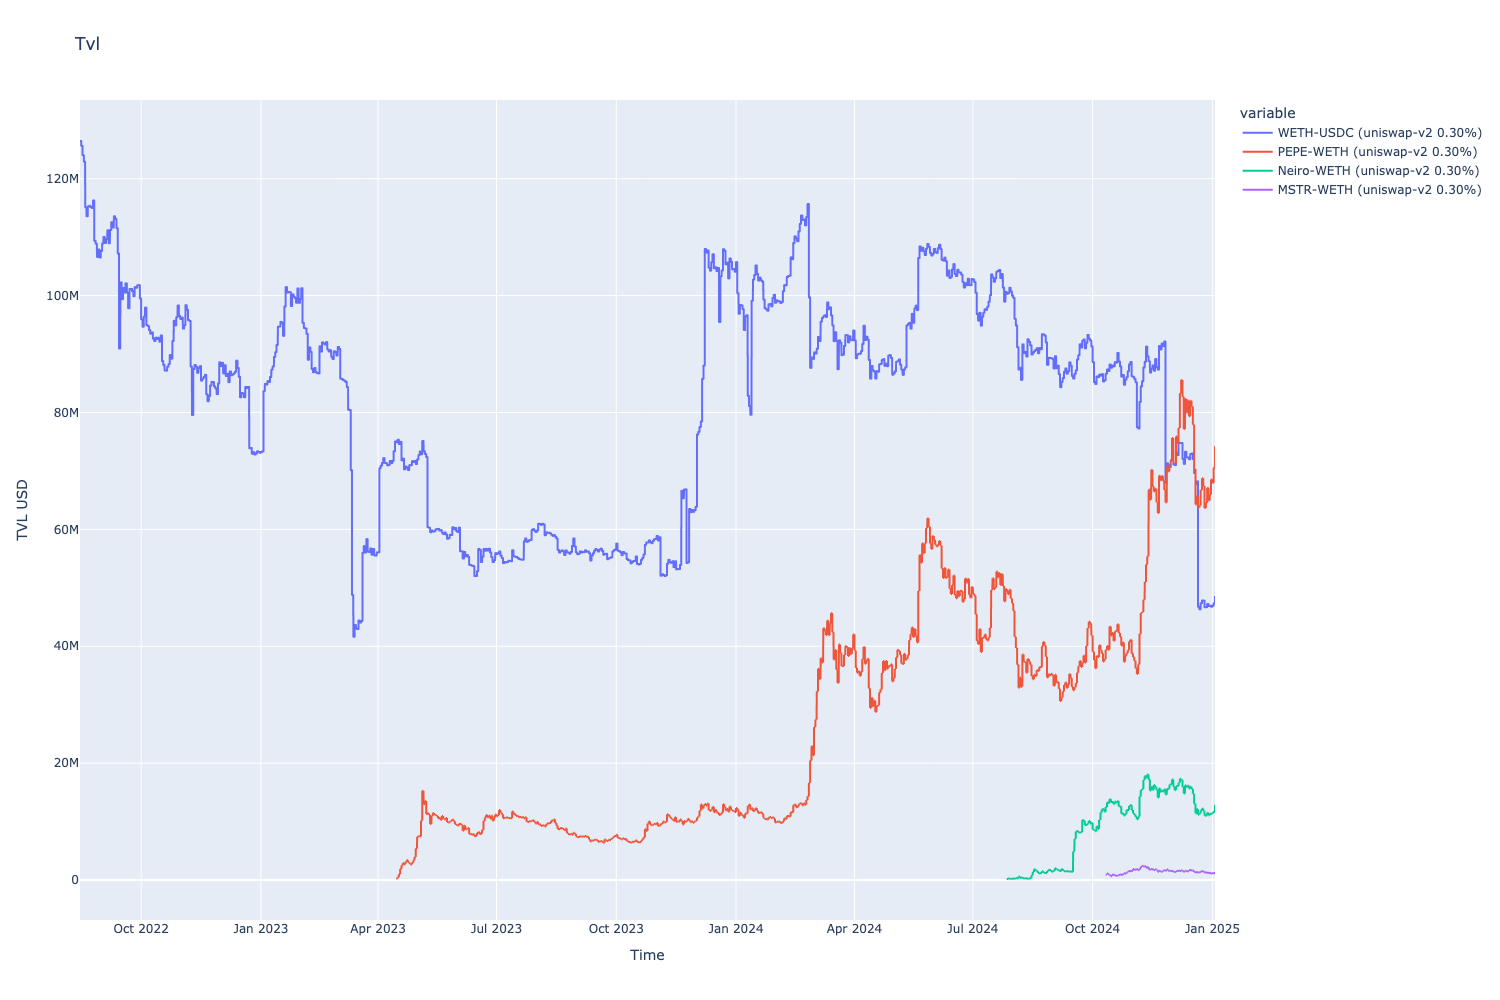

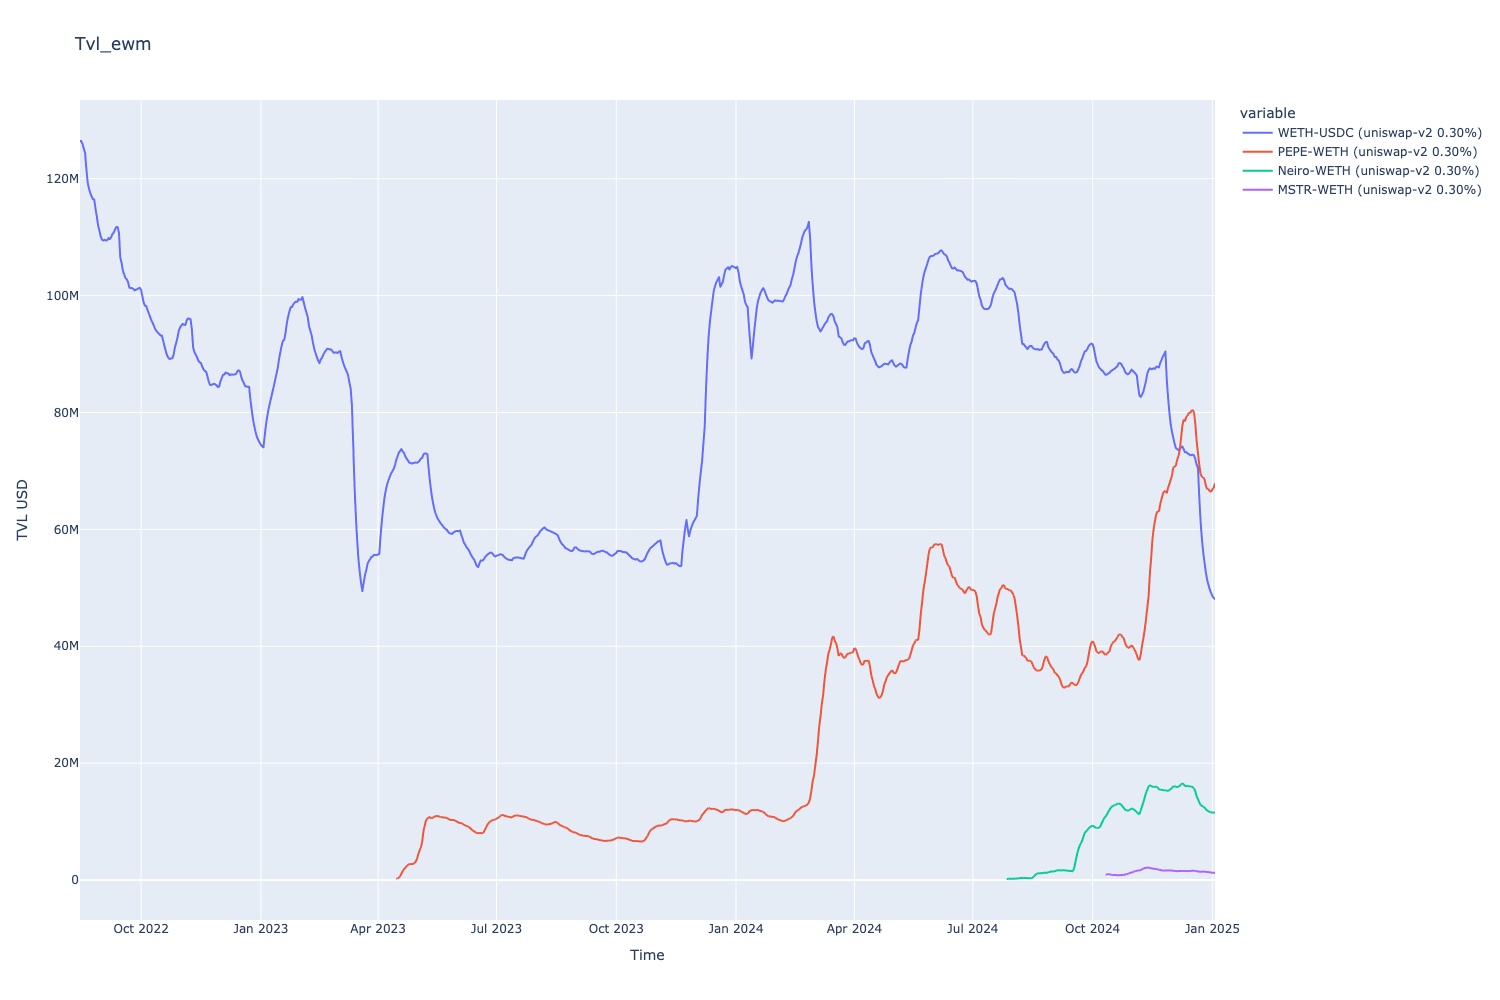

In [25]:
import plotly.express as px

selected_assets = ["WETH", "PEPE", "Neiro", "MSTR"]
checked_indicators = ["tvl", "tvl_ewm"]

for indicator_name in checked_indicators:

    data = {}
    for symbol in selected_assets:
        pair = token_map[symbol]
        label = f"{pair.get_ticker()} ({pair.exchange_name} {pair.fee:.2%})"
        data[label] = series = indicator_data.get_indicator_series(indicator_name, pair=pair)

        if series is None or len(series) == 0:
            print(f"Asset {symbol} has no data for {indicator_name}")

    df = pd.DataFrame(data)
    fig = px.line(df, title=f"{indicator_name.capitalize()}")
    fig.update_layout(showlegend=True)
    fig.update_yaxes(title=f"TVL USD")
    fig.update_xaxes(title="Time")
    fig.show()

# Included tokens

- Get the list of included tokens on the last round

In [26]:
import pandas as pd

timestamp = pd.Timestamp("2025-01-02 00:00:00")

included_pairs = indicator_data.get_indicator_series(
    "inclusion_criteria",
)

tvl = indicator_data.get_indicator_data_pairs_combined("tvl")

included_pairs_last = included_pairs[timestamp]

data = []
for pair_id in included_pairs_last:
    data.append({
        "pair_id": pair_id,
        "ticker": strategy_universe.get_pair_by_id(pair_id).get_ticker(),
        "tvl_usd": f"{tvl.get((pair_id, timestamp)) or 0:,.0f}",
    })

df = pd.DataFrame(data)
display(df)

/Users/moo/code/trade-executor/tradeexecutor/strategy/pandas_trader/strategy_input.py:763: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.



pair_id          ticker     tvl_usd
0   4394761       MSTR-WETH   1,189,720
1   3242770        NPC-WETH   4,679,361
2   3822867      NEIRO-WETH  11,752,835
3   3361302       BCAT-WETH     565,177
4   3808534      FIGHT-WETH     648,618
5   3660572       MAGA-WETH   2,625,310
6   5001247       MOON-WETH   1,702,375
7     68900      FLOKI-WETH  22,646,183
8      7717      LEASH-WETH     456,934
9   2833961     KIBSHI-WETH     933,406
10  4611117    PATRIOT-WETH   2,025,741
11  3376429       MEME-WETH     265,119
12  5035055      SHIFU-WETH   1,829,183
13  3311668   шайлушай-WETH   1,293,561
14  3319606        APX-WETH     916,876
15  3530041        RYU-WETH     749,067
16  3840058   TERMINUS-WETH   1,165,052
17  3573307       ANDY-WETH   5,626,484
18    83008      TSUKA-USDC     803,455
19  3679558     PEIPEI-WETH   2,491,857
20  3347784        JOE-WETH   2,839,527
21  4974667       PEPU-WETH   3,627,897
22  3698255      SHRUB-WETH   1,713,667
23  3552847      Kendu-WETH   1,191,396
24  3047249      TURBO-WETH     217,648
25  4306260       DOGE-WETH   6,532,643
26  3669332        FEG-WETH           0
27  3484249    PEPE2.0-WETH   1,150,296
28  3563618     STRUMP-WETH     471,514
29  3038307   pepecoin-WETH   7,856,232
30  4367972     SQGROW-WETH   2,851,672
31  3574627    BIRDDOG-WETH     629,075
32  3365484        DOG-WETH     406,405
33  3523948       PORK-WETH     682,634
34  2701164       BONE-WETH     161,383
35  4964467       CULT-WETH  12,436,633
36  3017331      TROLL-WETH   1,494,538
37  2894712    OPTIMUS-WETH     563,287
38  3018875        BOB-WETH   2,525,832
39  3574910      HOPPY-WETH   2,270,121
40  3445245       BYTE-WETH     913,893
41  4984458    MYSTERY-WETH     602,723
42  3308171       PSPS-WETH     637,170
43  3656844        GME-WETH   3,749,624
44  3402904       Bonk-WETH     201,306
45  3271833        SPX-WETH  16,677,884
46  3000217       KATA-WETH     237,169
47  4600219      PEEZY-WETH     168,024
48  3061151      LADYS-WETH   3,044,219
49  4372640    MOODENG-WETH   3,007,784
50  2734754      $ROAR-WETH     465,419
51  3213475      BRETT-WETH     573,182
52  3031971      JESUS-WETH   1,919,665
53  4636069        SBR-WETH   1,362,301
54  2697640       SHIB-WETH   1,276,307
55  3073705       BOBO-WETH   3,711,881
56  4353961       PHIL-WETH   3,085,668
57  3634091       WOLF-WETH   4,121,416
58  3026347       OSAK-WETH   2,113,149
59  2785201      LMEOW-WETH   2,164,360
60  4999091     KEKIUS-WETH   2,961,470
61  3010484       PEPE-WETH  70,601,187
62  3226046        Mog-WETH  22,173,322
63  4659392   DOGECAST-WETH     803,162
64    37316       ELON-WETH  16,249,276
65  4388038  NASDAQ420-WETH     409,224
66  3015124      WOJAK-WETH   6,823,569
67  3335894     KIZUNA-WETH     341,817
68  5043670     NUMBER-WETH     901,641
69  3822814      Neiro-WETH  11,752,835
70  3702498    $MaxETH-WETH     520,851
71  4687332       SLAP-WETH   3,665,379
72  3430630        ZYN-WETH   1,630,318
73  3079399       PIKA-WETH     933,846
74  3377643       GROK-WETH   3,248,176
75  3054571        BAD-WETH   1,501,488
76  3367917      Kekec-WETH   1,265,227
77  4381174      BBONK-USDT      71,536
78  3073784    BITCOIN-WETH  12,020,079
79  4702714       REKT-WETH   2,768,731
80  5051643      STARS-WETH     490,346
81  2713084        SHI-WETH   2,158,600
82  3675389       TROG-WETH     660,449
83  3576318        APU-WETH   4,913,434